# Cross-Country Epidemic Viz 

In [1]:
library(LalRUtils)
libreq(data.table, tidyverse, sf, janitor, anytime, lubridate, plotly, zoo, patchwork, ggrepel)
theme_set(lal_plot_theme_d())
options(repr.plot.width = 20, repr.plot.height=12)

      wants        loaded
 [1,] "data.table" TRUE  
 [2,] "tidyverse"  TRUE  
 [3,] "sf"         TRUE  
 [4,] "janitor"    TRUE  
 [5,] "anytime"    TRUE  
 [6,] "lubridate"  TRUE  
 [7,] "plotly"     TRUE  
 [8,] "zoo"        TRUE  
 [9,] "patchwork"  TRUE  
[10,] "ggrepel"    TRUE  


# JHU

In [2]:
jhu_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
cases = fread(jhu_cases_url)

jhu_deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
deaths = fread(jhu_deaths_url)

In [3]:
name_clean = function(df) setnames(df, str_replace(colnames(df), "/", "_"))

In [4]:
cases_long = melt(cases, id.vars = c("Province/State", "Country/Region", "Lat", "Long"), 
    variable.name = "date", value.name = "cases") 
name_clean(cases_long)

deaths_long = melt(deaths, id.vars = c("Province/State", "Country/Region", "Lat", "Long"), 
    variable.name = "date", value.name = "deaths") 
name_clean(deaths_long)
deaths_long[, c('Lat', 'Long') := NULL]

In [5]:
df = merge(cases_long, deaths_long,
      by = c("Province_State", "Country_Region", "date"), all.x = T)
df[, date := mdy(date)]
df[, day := weekdays(date)]
df[is.na(df)] = 0
df %>% glimpse

Rows: 40,698
Columns: 8
$ Province_State <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", ""…
$ Country_Region <chr> "Afghanistan", "Afghanistan", "Afghanistan", "Afghanis…
$ date           <date> 2020-01-22, 2020-01-23, 2020-01-24, 2020-01-25, 2020-…
$ Lat            <dbl> 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33…
$ Long           <dbl> 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65…
$ cases          <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ deaths         <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ day            <chr> "Wednesday", "Thursday", "Friday", "Saturday", "Sunday…


In [6]:
fwrite(df, "data/jhu_panel.csv")

## Country Level

In [7]:
country_ts = df[, lapply(.SD, sum) , by = .(Country_Region, date), .SDcols = c("cases", "deaths")]

In [8]:
(t10countries = country_ts[date == max(country_ts$date)][order(-cases)][1:10])

Country_Region date       cases   deaths
1  US             2020-06-22 2312302 120402
2  Brazil         2020-06-22 1106470  51271
3  Russia         2020-06-22  591465   8196
4  India          2020-06-22  440215  14011
5  United Kingdom 2020-06-22  306761  42731
6  Peru           2020-06-22  257447   8223
7  Chile          2020-06-22  246963   4502
8  Spain          2020-06-22  246504  28324
9  Italy          2020-06-22  238720  34657
10 Iran           2020-06-22  207525   9742

In [9]:
t10_subset = country_ts[Country_Region %in% t10countries$Country_Region]
setorder(t10_subset, Country_Region, date)
# normalise time from first day with >= 10 cases
t10_subset[cases >= 10,  c_time := seq_len(.N), by = .(Country_Region)]
t10_subset[deaths >= 1, d_time := seq_len(.N), by = .(Country_Region)]

In [10]:
setorder(t10_subset, Country_Region, date)
t10_subset[, new_cases  := cases - shift(cases), by = .(Country_Region)]
t10_subset[, new_deaths := deaths - shift(deaths), by = .(Country_Region)]
t10_subset[, cfr := deaths/cases]
smoothvars = c('cases', 'new_cases', 'deaths', 'new_deaths', 'cfr')
t10_subset[, paste0("rm7_", smoothvars) := lapply(.SD, rollmean, k = 7, fill = NA, na.pad = T), 
   by = .(Country_Region), .SDcols = smoothvars]

In [11]:
t10_subset[, label := ifelse(date == max(date), Country_Region, NA)]

## Cumulative and New Cases / Deaths 

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 366 rows containing missing values (geom_point).”
Warning message:
“Removed 397 row(s) containing missing values (geom_path).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 410 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 370 rows 

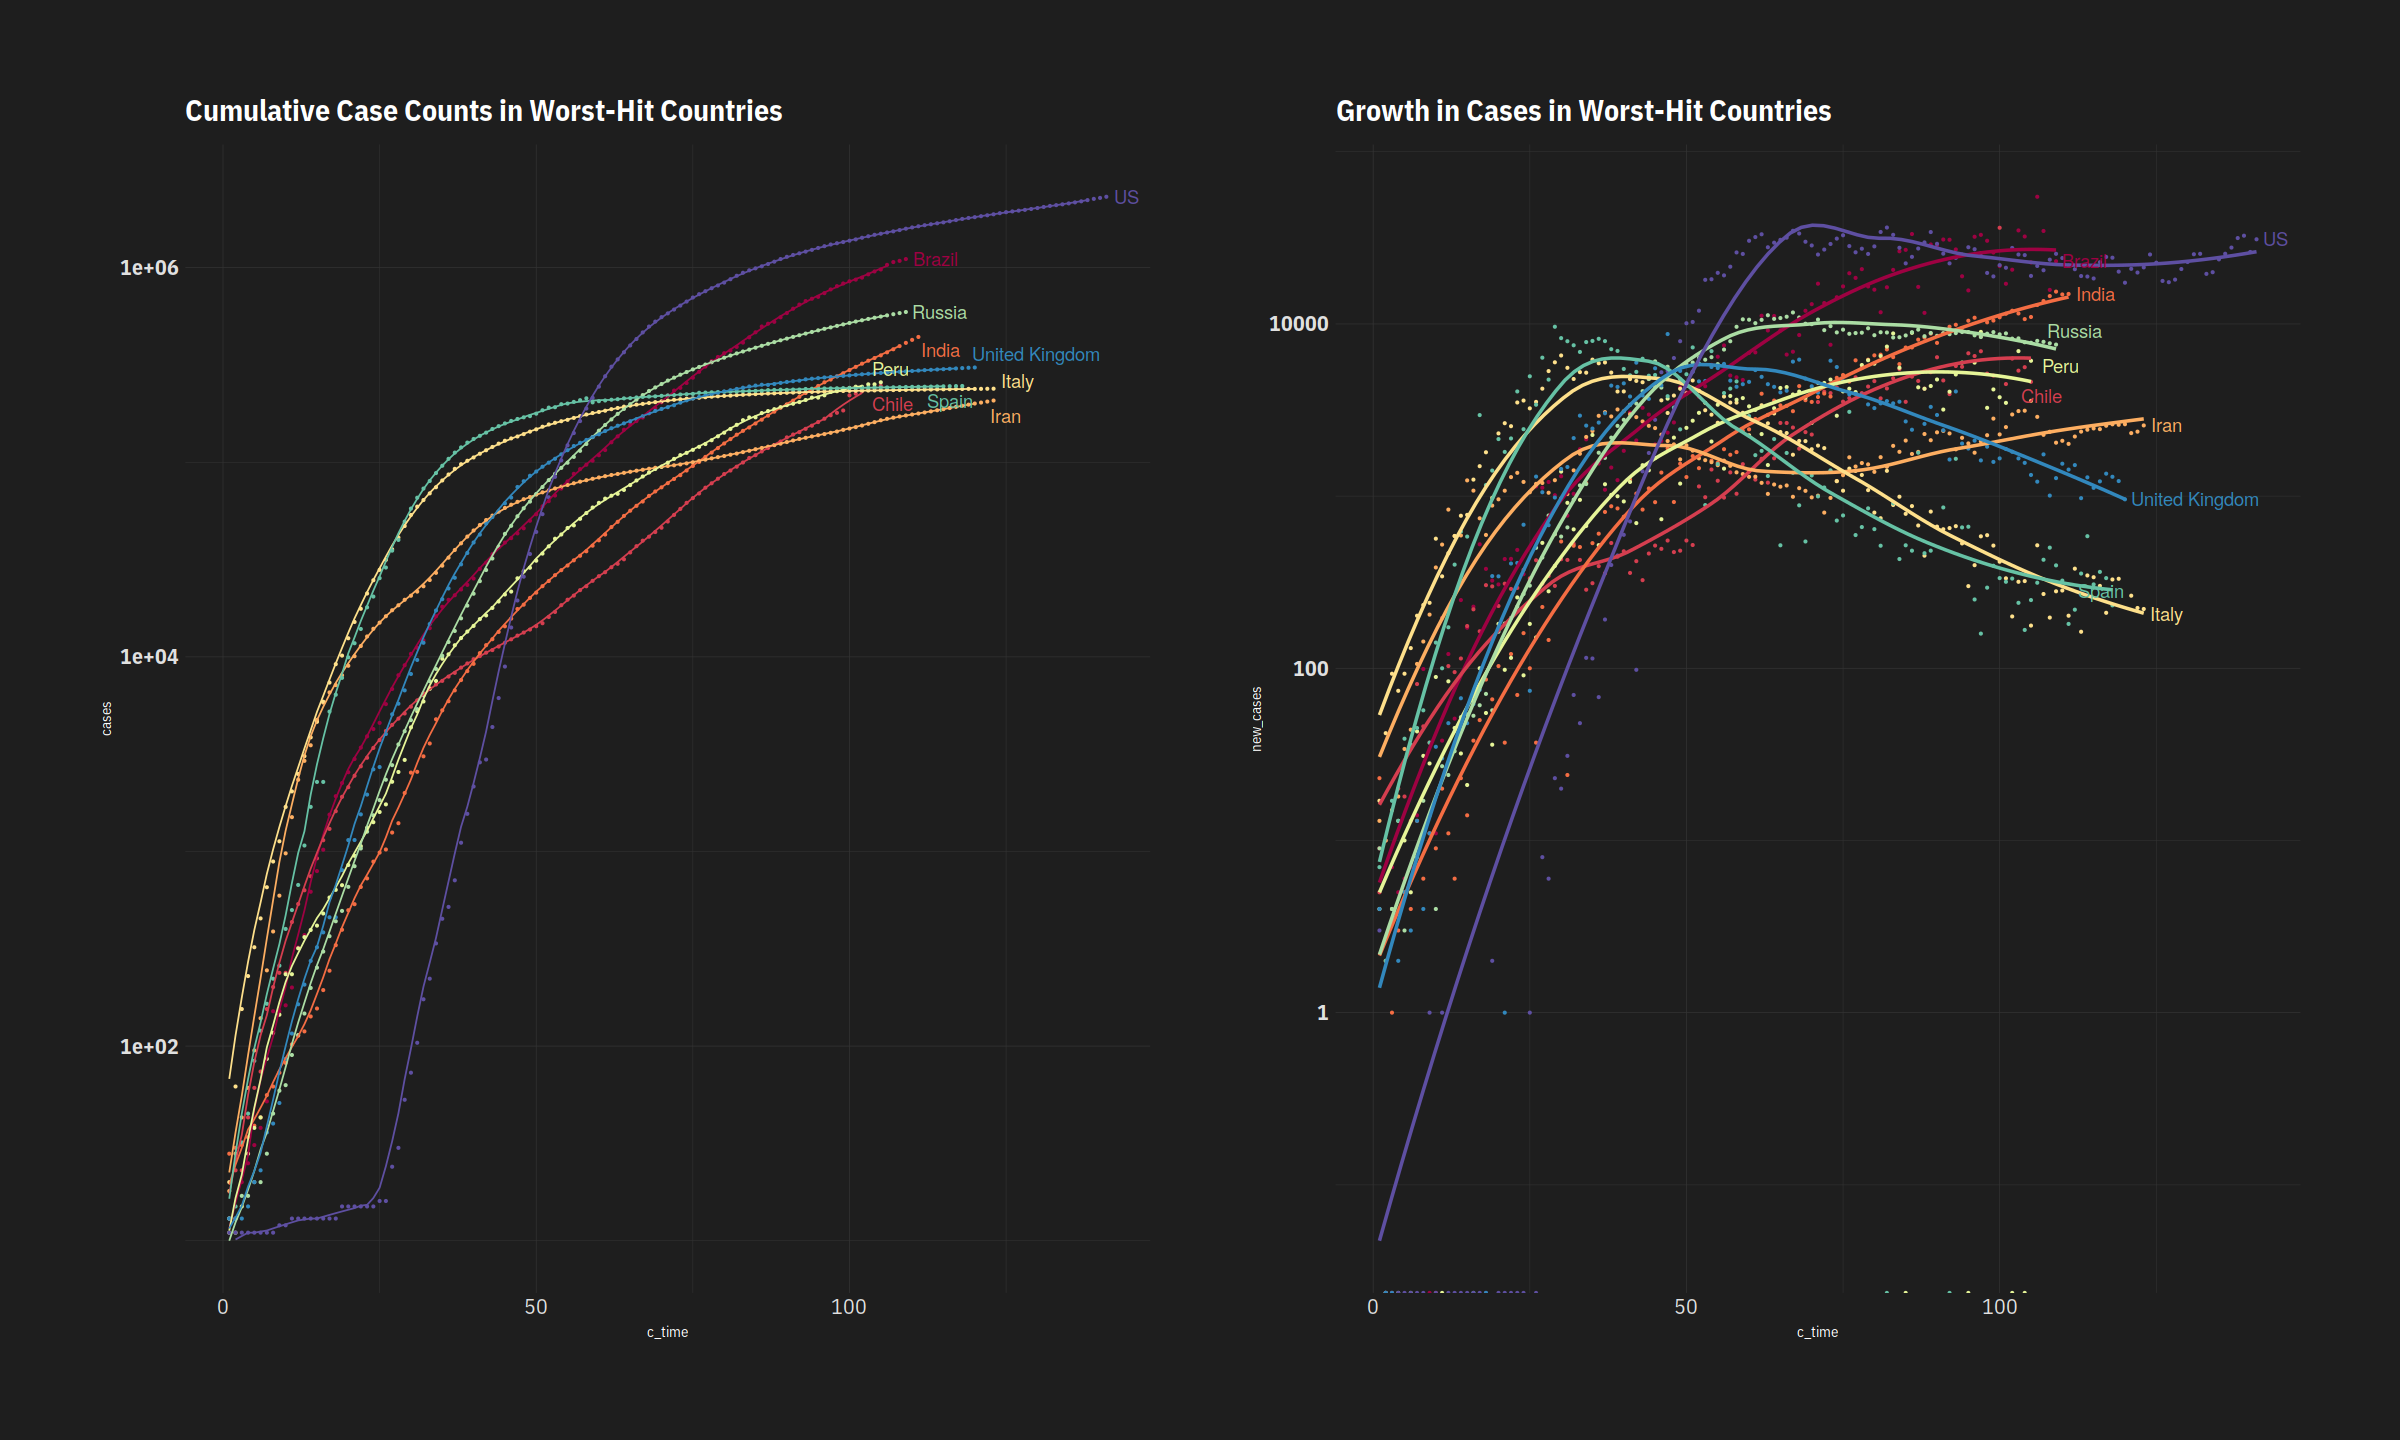

In [12]:
p1 = ggplot(t10_subset,
           aes(x = c_time, y = cases, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = cases), size = 0.5) + geom_line(aes(y = rm7_cases)) + 
    scale_y_log10(limits = c(10, NA)) + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Cumulative Case Counts in Worst-Hit Countries') 

p2 = 
    t10_subset %>% 
    ggplot(aes(x = c_time,y = new_cases, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = new_cases), size = 0.5) + 
#     geom_line(aes(y = rm7_new_cases)) + 
    geom_smooth(se = F) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Growth in Cases in Worst-Hit Countries')

(p1 | p2 )

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 527 rows containing missing values (geom_point).”
Warning message:
“Removed 555 row(s) containing missing values (geom_path).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 505 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 462 rows 

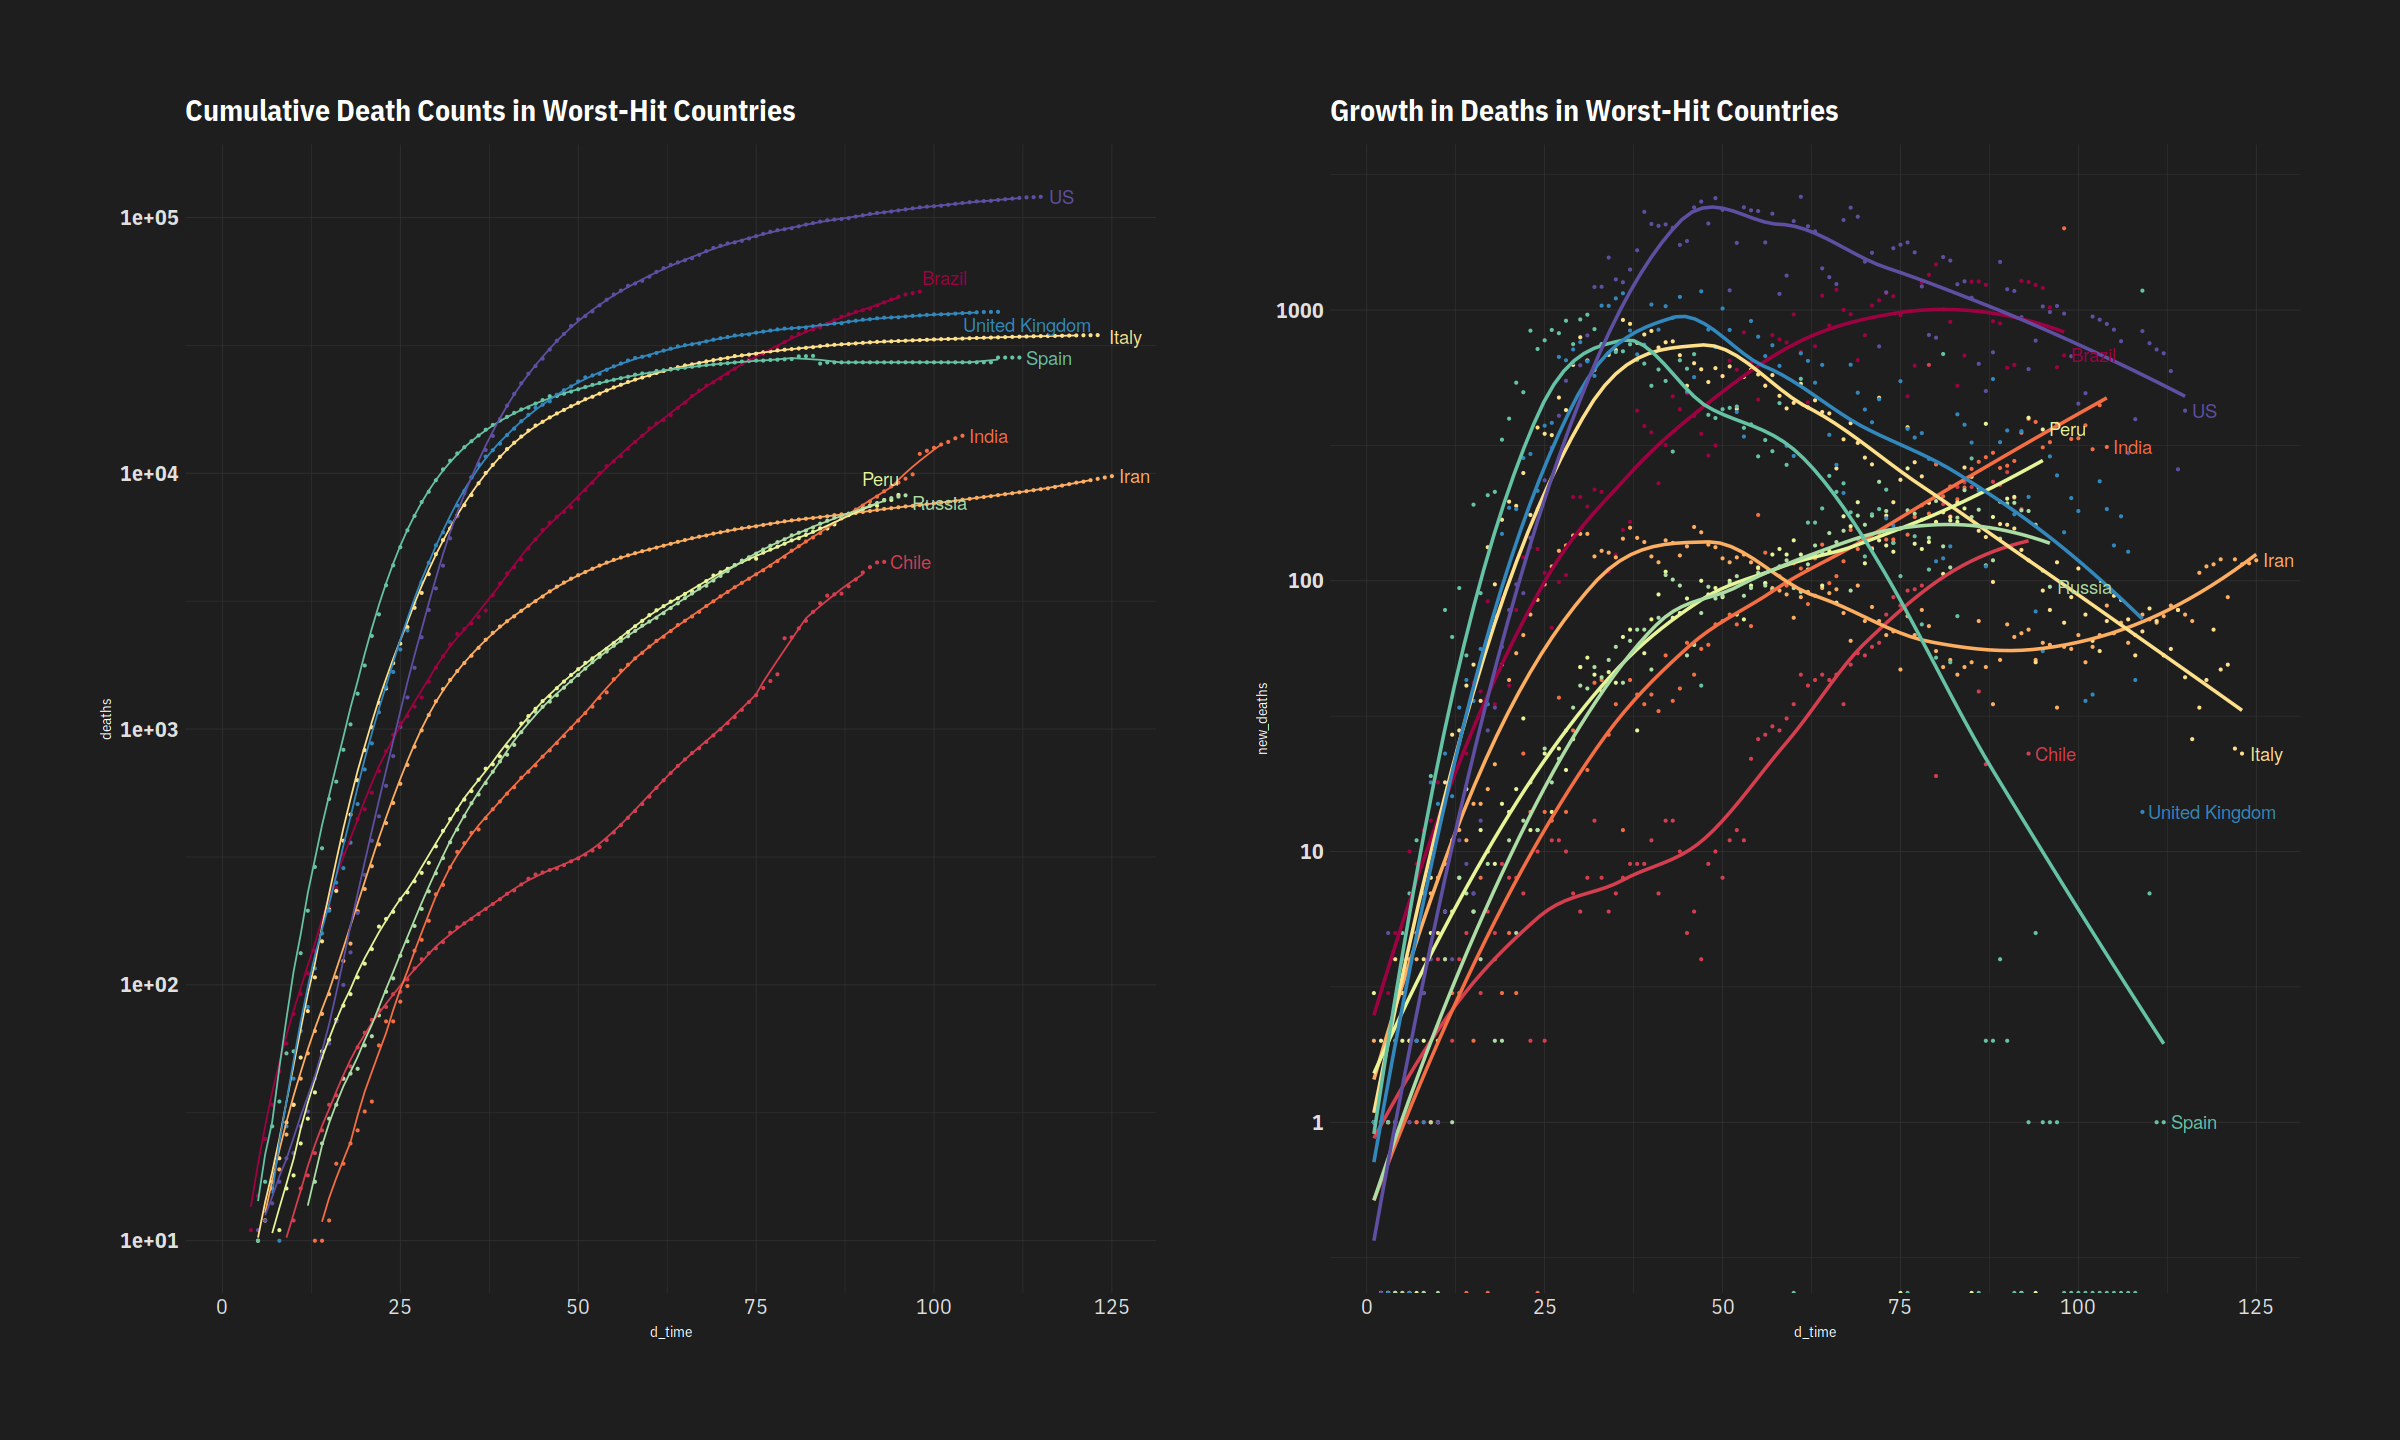

In [13]:
p1 = ggplot(t10_subset,
           aes(x = d_time, y = deaths, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = deaths), size = 0.5) + geom_line(aes(y = rm7_deaths)) + 
    scale_y_log10(limits = c(10, NA)) + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Cumulative Death Counts in Worst-Hit Countries') 

p2 =  t10_subset %>% 
    ggplot(aes(x = d_time, y = new_deaths, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = new_deaths), size = 0.5) + 
    geom_smooth(se = F) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Growth in Deaths in Worst-Hit Countries')

(p1 | p2 )

## Case Fatality Rate

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 462 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 462 rows containing missing values (geom_point).”
Warning message:
“Removed 4 rows containing missing values (geom_smooth).”


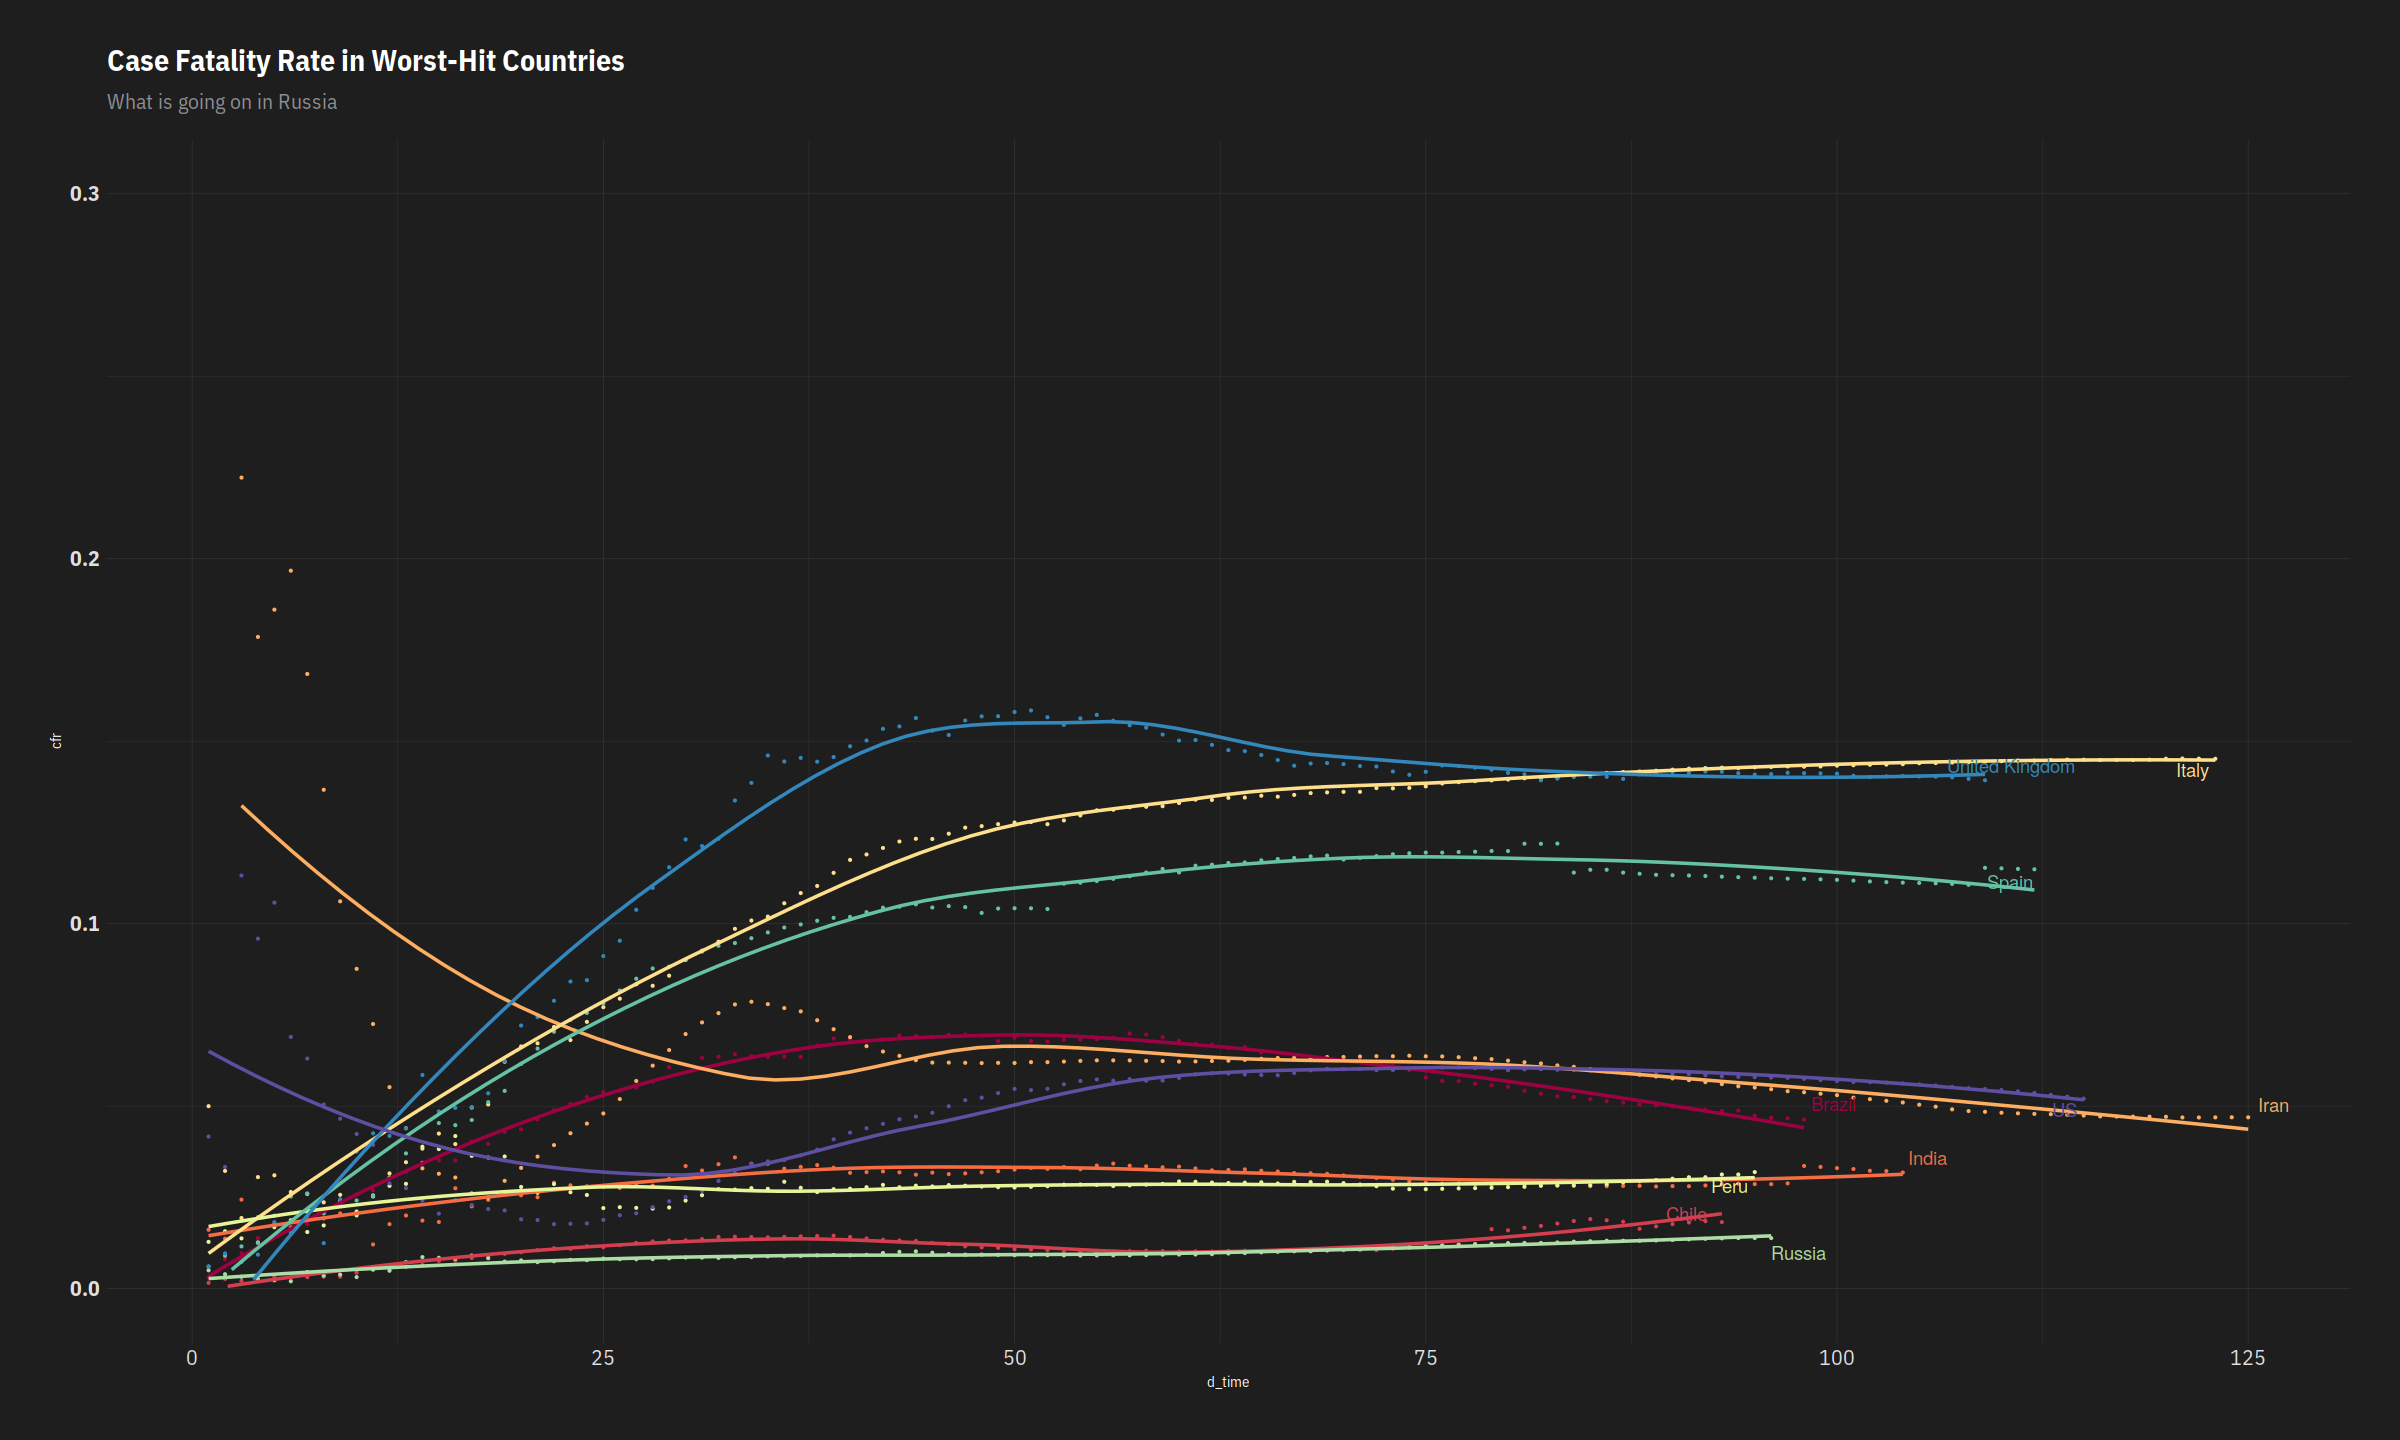

In [14]:
p3 =  t10_subset %>% 
    ggplot(aes(x = d_time, y = cfr, group = Country_Region, colour = Country_Region)) + 
    geom_point(size = 0.5) + 
#     geom_line(aes(y = rm7_cfr)) + 
    geom_smooth(se = F) +
    ylim(c(0, 0.3)) +
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      na.rm = TRUE) +
    labs(title = 'Case Fatality Rate in Worst-Hit Countries', subtitle = "What is going on in Russia")
p3

## Shares

In [15]:
t10_subset[, denom_cases := sum(rm7_new_cases), by = date][, 
            denom_deaths := sum(rm7_new_deaths), by = date]
t10_subset[, newcase_share := rm7_new_cases / denom_cases][, 
            newdeath_share := rm7_new_deaths /denom_deaths]

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 30 rows containing missing values (position_stack).”
Warning message:
“Removed 47 rows containing missing values (position_stack).”


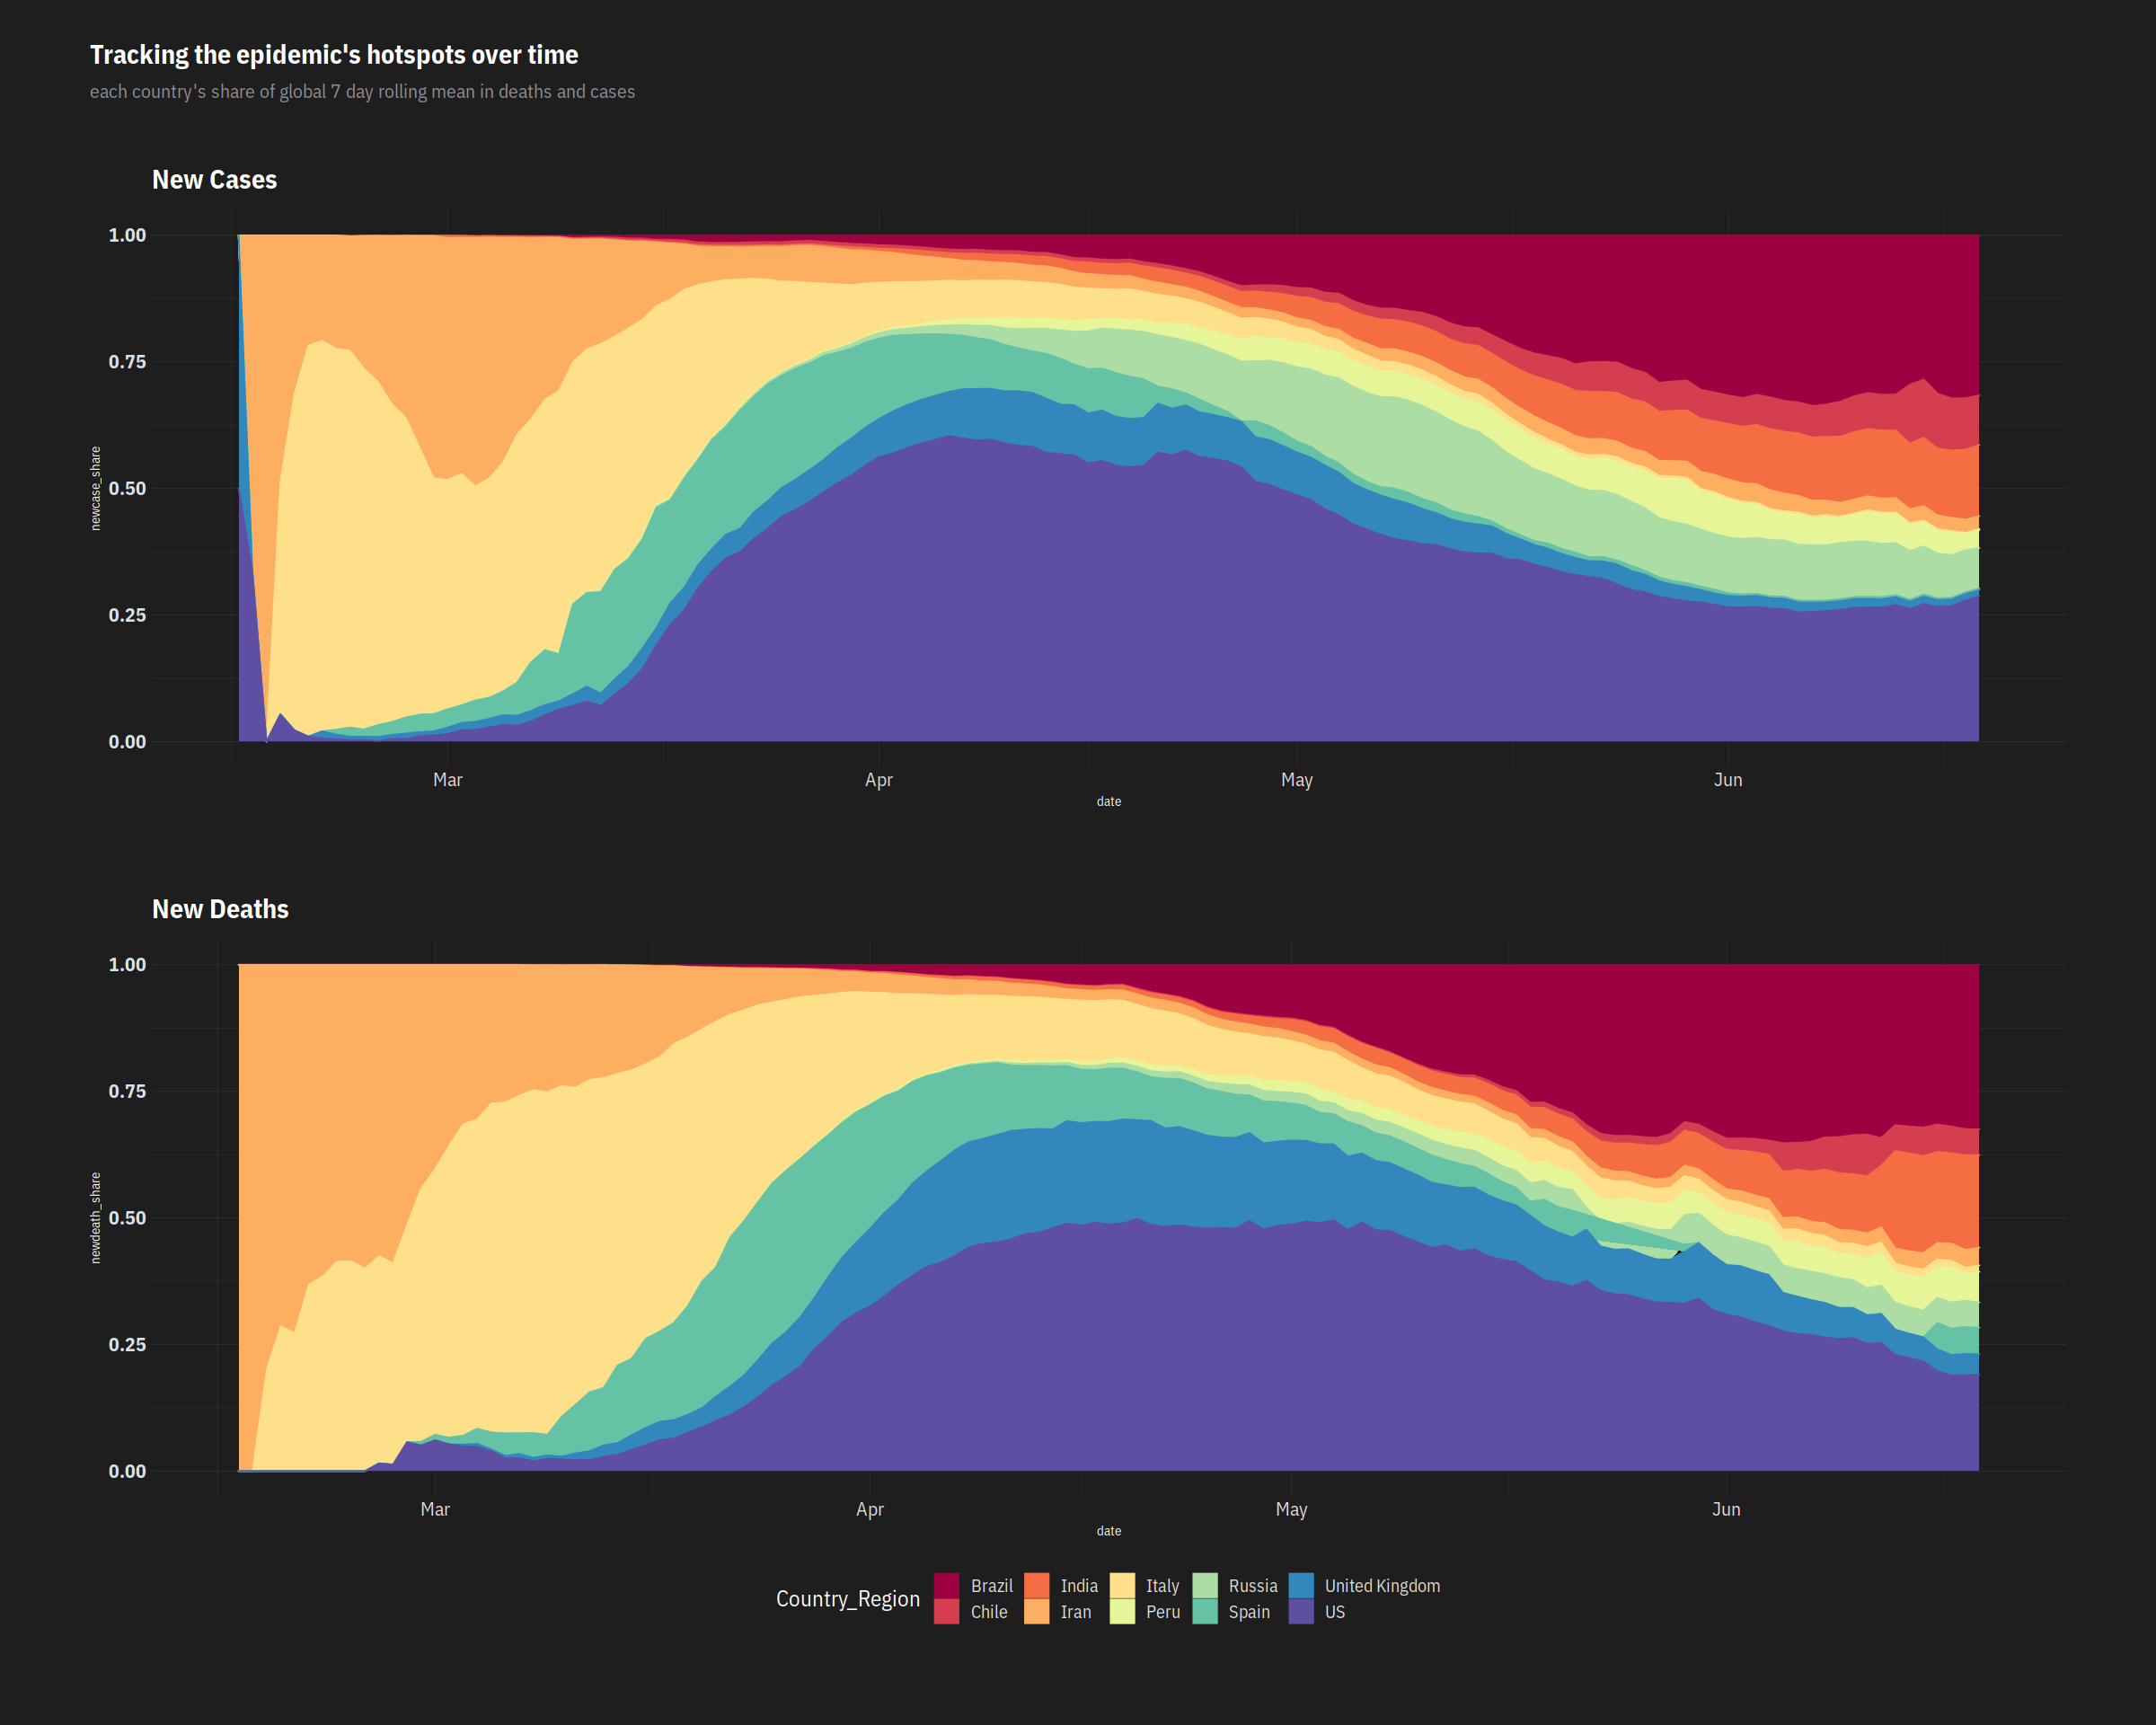

In [16]:
p1 = ggplot(t10_subset[date >="2020-02-15"], aes(x = date, y = newcase_share, fill = Country_Region, colour = Country_Region)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+ ylim(c(0, 1)) +
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases") + theme(legend.position = "None")
p2 = ggplot(t10_subset[date >="2020-02-15"], aes(x = date, y = newdeath_share, fill = Country_Region, colour = Country_Region)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+ ylim(c(0, 1)) +
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Deaths")

options(repr.plot.width = 20, repr.plot.height = 16)
(p = (p1 / p2 ) + plot_annotation(title = "Tracking the epidemic's hotspots over time", 
                                  subtitle = "each country's share of global 7 day rolling mean in deaths and cases"))

In [17]:
ggsave("carpet_plot_xc.png", p, width = 20, height = 16)

Warning message:
“Removed 30 rows containing missing values (position_stack).”
Warning message:
“Removed 47 rows containing missing values (position_stack).”


# OWID 

In [18]:
owid = fread("https://covid.ourworldindata.org/data/owid-covid-data.csv")
owid[, d := ymd(date)]
owid %>% glimpse

Rows: 25,714
Columns: 35
$ iso_code                        <chr> "AFG", "AFG", "AFG", "AFG", "AFG", "A…
$ continent                       <chr> "Asia", "Asia", "Asia", "Asia", "Asia…
$ location                        <chr> "Afghanistan", "Afghanistan", "Afghan…
$ date                            <chr> "2019-12-31", "2020-01-01", "2020-01-…
$ total_cases                     <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ new_cases                       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ total_deaths                    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ new_deaths                      <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ total_cases_per_million         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ new_cases_per_million           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ total_deaths_per_million        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ new_deaths_per_million          <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ total_tests              

In [19]:
fwrite(owid, "data/owid_covid.csv")

In [20]:
all_countries_xs = owid[location!="World"][
    order(-d)][
    , .SD[1], by = .(iso_code)]
(t10 = all_countries_xs[order(-total_cases)][1:10])
#  [order(-total_cases)][1:10])

iso_code continent     location       date       total_cases new_cases
1  USA      North America United States  2020-06-23 2312302     31390    
2  BRA      South America Brazil         2020-06-23 1106470     21432    
3  RUS      Europe        Russia         2020-06-23  592280      7600    
4  IND      Asia          India          2020-06-23  440215     14933    
5  GBR      Europe        United Kingdom 2020-06-23  305289       958    
6  PER      South America Peru           2020-06-23  254936         0    
7  CHL      South America Chile          2020-06-23  246963      4608    
8  ESP      Europe        Spain          2020-06-22  246504       232    
9  ITA      Europe        Italy          2020-06-23  238720       221    
10 IRN      Asia          Iran           2020-06-23  207525      2573    
   total_deaths new_deaths total_cases_per_million new_cases_per_million ⋯
1  120402       427         6986                    94.833               ⋯
2   51271       654         5205                   100.828               ⋯
3    8206        95         4059                    52.078               ⋯
4   14011       312          319                    10.821               ⋯
5   42647        15         4497                    14.112               ⋯
6    8045         0         7732                     0.000               ⋯
7    4502        23        12919                   241.052               ⋯
8   28324         1         5272                     4.962               ⋯
9   34657        23         3948                     3.655               ⋯
10   9742       119         2471                    30.634               ⋯
   gdp_per_capita extreme_poverty cvd_death_rate diabetes_prevalence
1  54225           1.2            151.09         10.79              
2  14103           3.4            177.96          8.11              
3  24766           0.1            431.30          6.18              
4   6427          21.2            282.28         10.39              
5  39753           0.2            122.14          4.28              
6  12237           3.5             85.75          5.95              
7  22767           1.3            127.99          8.46              
8  34272           1.0             99.40          7.17              
9  35220           2.0            113.15          4.78              
10 19083           0.2            270.31          9.59              
   female_smokers male_smokers handwashing_facilities
1  19.1           24.6            NA                 
2  10.1           17.9            NA                 
3  23.4           58.3            NA                 
4   1.9           20.6         59.55                 
5  20.0           24.7            NA                 
6   4.8             NA            NA                 
7  34.2           41.5            NA                 
8  27.4           31.4            NA                 
9  19.8           27.8            NA                 
10  0.8           21.1            NA                 
   hospital_beds_per_thousand life_expectancy d         
1  2.77                       78.86           2020-06-23
2  2.20                       75.88           2020-06-23
3  8.05                       72.58           2020-06-23
4  0.53                       69.66           2020-06-23
5  2.54                       81.32           2020-06-23
6  1.60                       76.74           2020-06-23
7  2.11                       80.18           2020-06-23
8  2.97                       83.56           2020-06-22
9  3.18                       83.51           2020-06-23
10 1.50                       76.68           2020-06-23

In [21]:
owid_t10_subset = owid[location %in% t10$location]

vars = c('new_cases', 'new_deaths', 'new_tests')
owid_t10_subset[, paste0('denom_', vars):= lapply(.SD, sum), by = date, .SDcols = vars]

owid_t10_subset[, `:=`(
            newcase_share  = new_cases / denom_new_cases,
            newdeath_share = new_deaths / denom_new_deaths,
            newtest_share  = new_tests / denom_new_tests
    )][ newcase_share < 0, newcase_share := 0]

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 79 rows containing missing values (position_stack).”
Warning message:
“Removed 97 rows containing missing values (position_stack).”


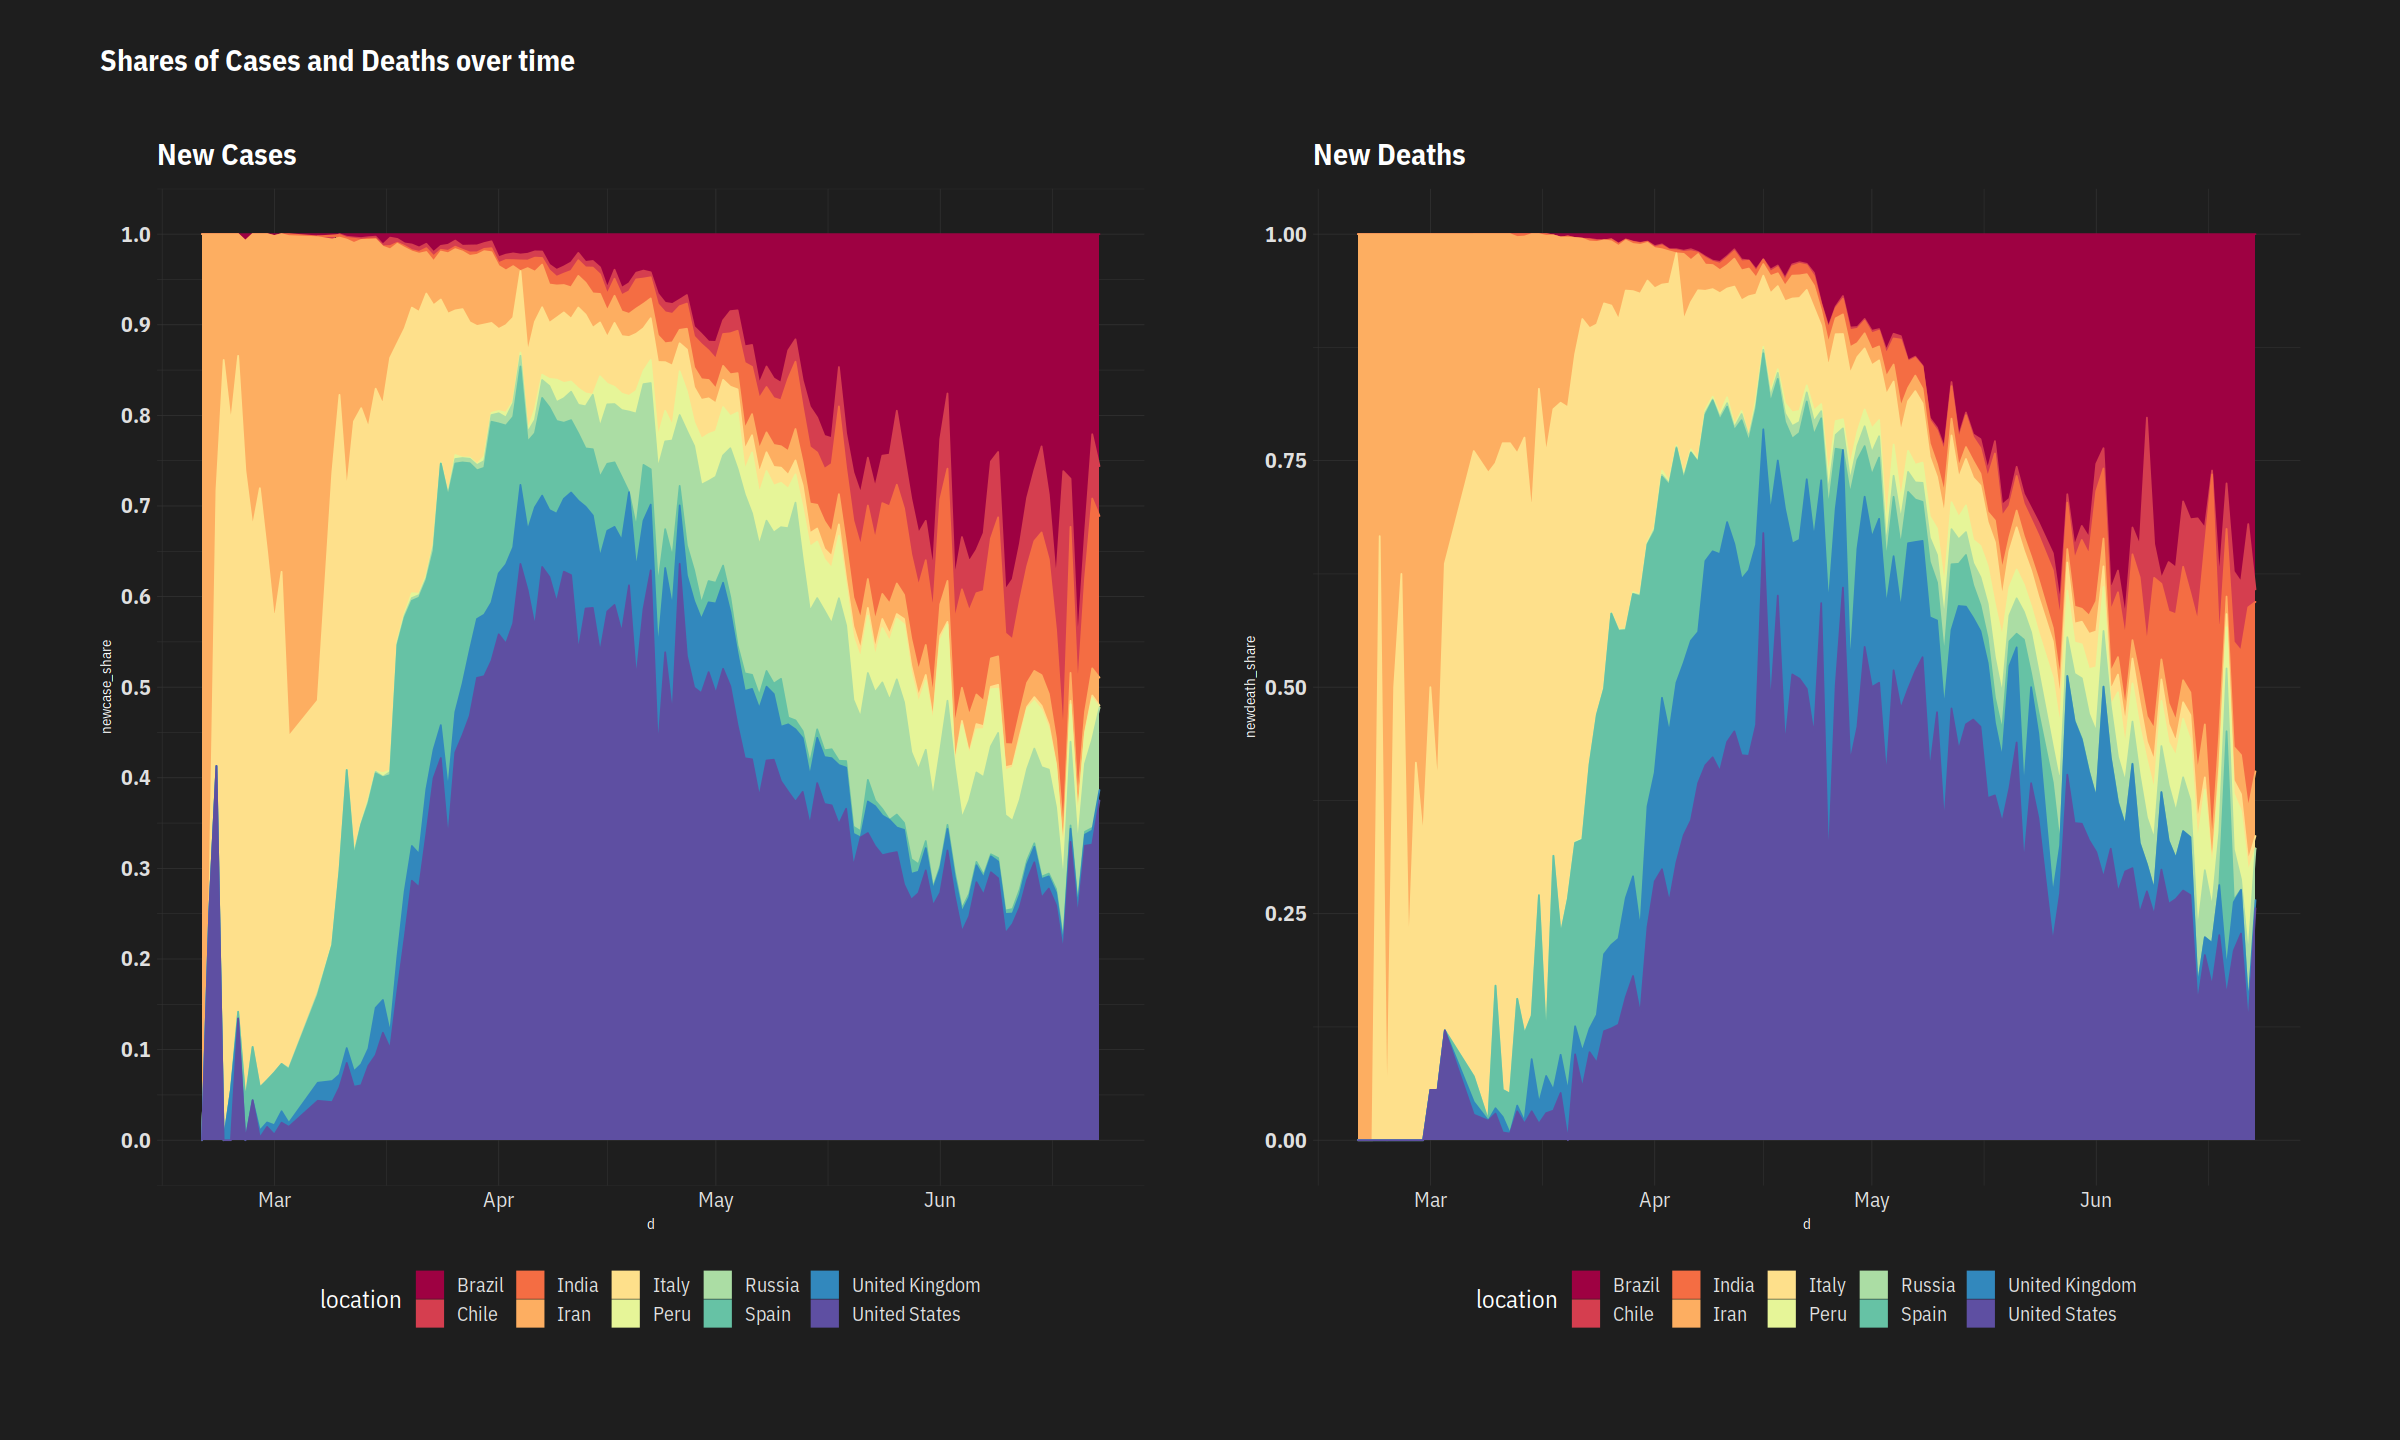

In [22]:
p1 = ggplot(owid_t10_subset[d >="2020-02-15"], aes(x = d, y = newcase_share, fill = location, colour = location)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases")
p2 = ggplot(owid_t10_subset[d >="2020-02-15"], aes(x = d, y = newdeath_share, fill = location, colour = location)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") + ylim(c(0, 1)) +
    ggtitle("New Deaths")
options(repr.plot.width = 20, repr.plot.height = 12)
(p1 | p2 ) + plot_annotation(title = "Shares of Cases and Deaths over time")

## Country Profiles 

In [23]:
country_plot = function(country){
    npl = owid[location == country][order(-date)]
    p1 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_cases)) + scale_y_log10() + 
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('Total Cases') 
    
    p2 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_cases)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('New Cases')
    
    p3 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_deaths)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('Total Deaths')
    
    p4 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_deaths)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('New Deaths')

    p5 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_tests)) + scale_y_log10() + 
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('Total Tests')

    p6 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_tests)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('New Tests')
    suppressMessages(suppressWarnings(print(
        (p5 | p6) / (p1 | p2) / (p3 | p4) + plot_annotation(title = paste0("Covid Profile : ", country))
    )))
}


## South Asia

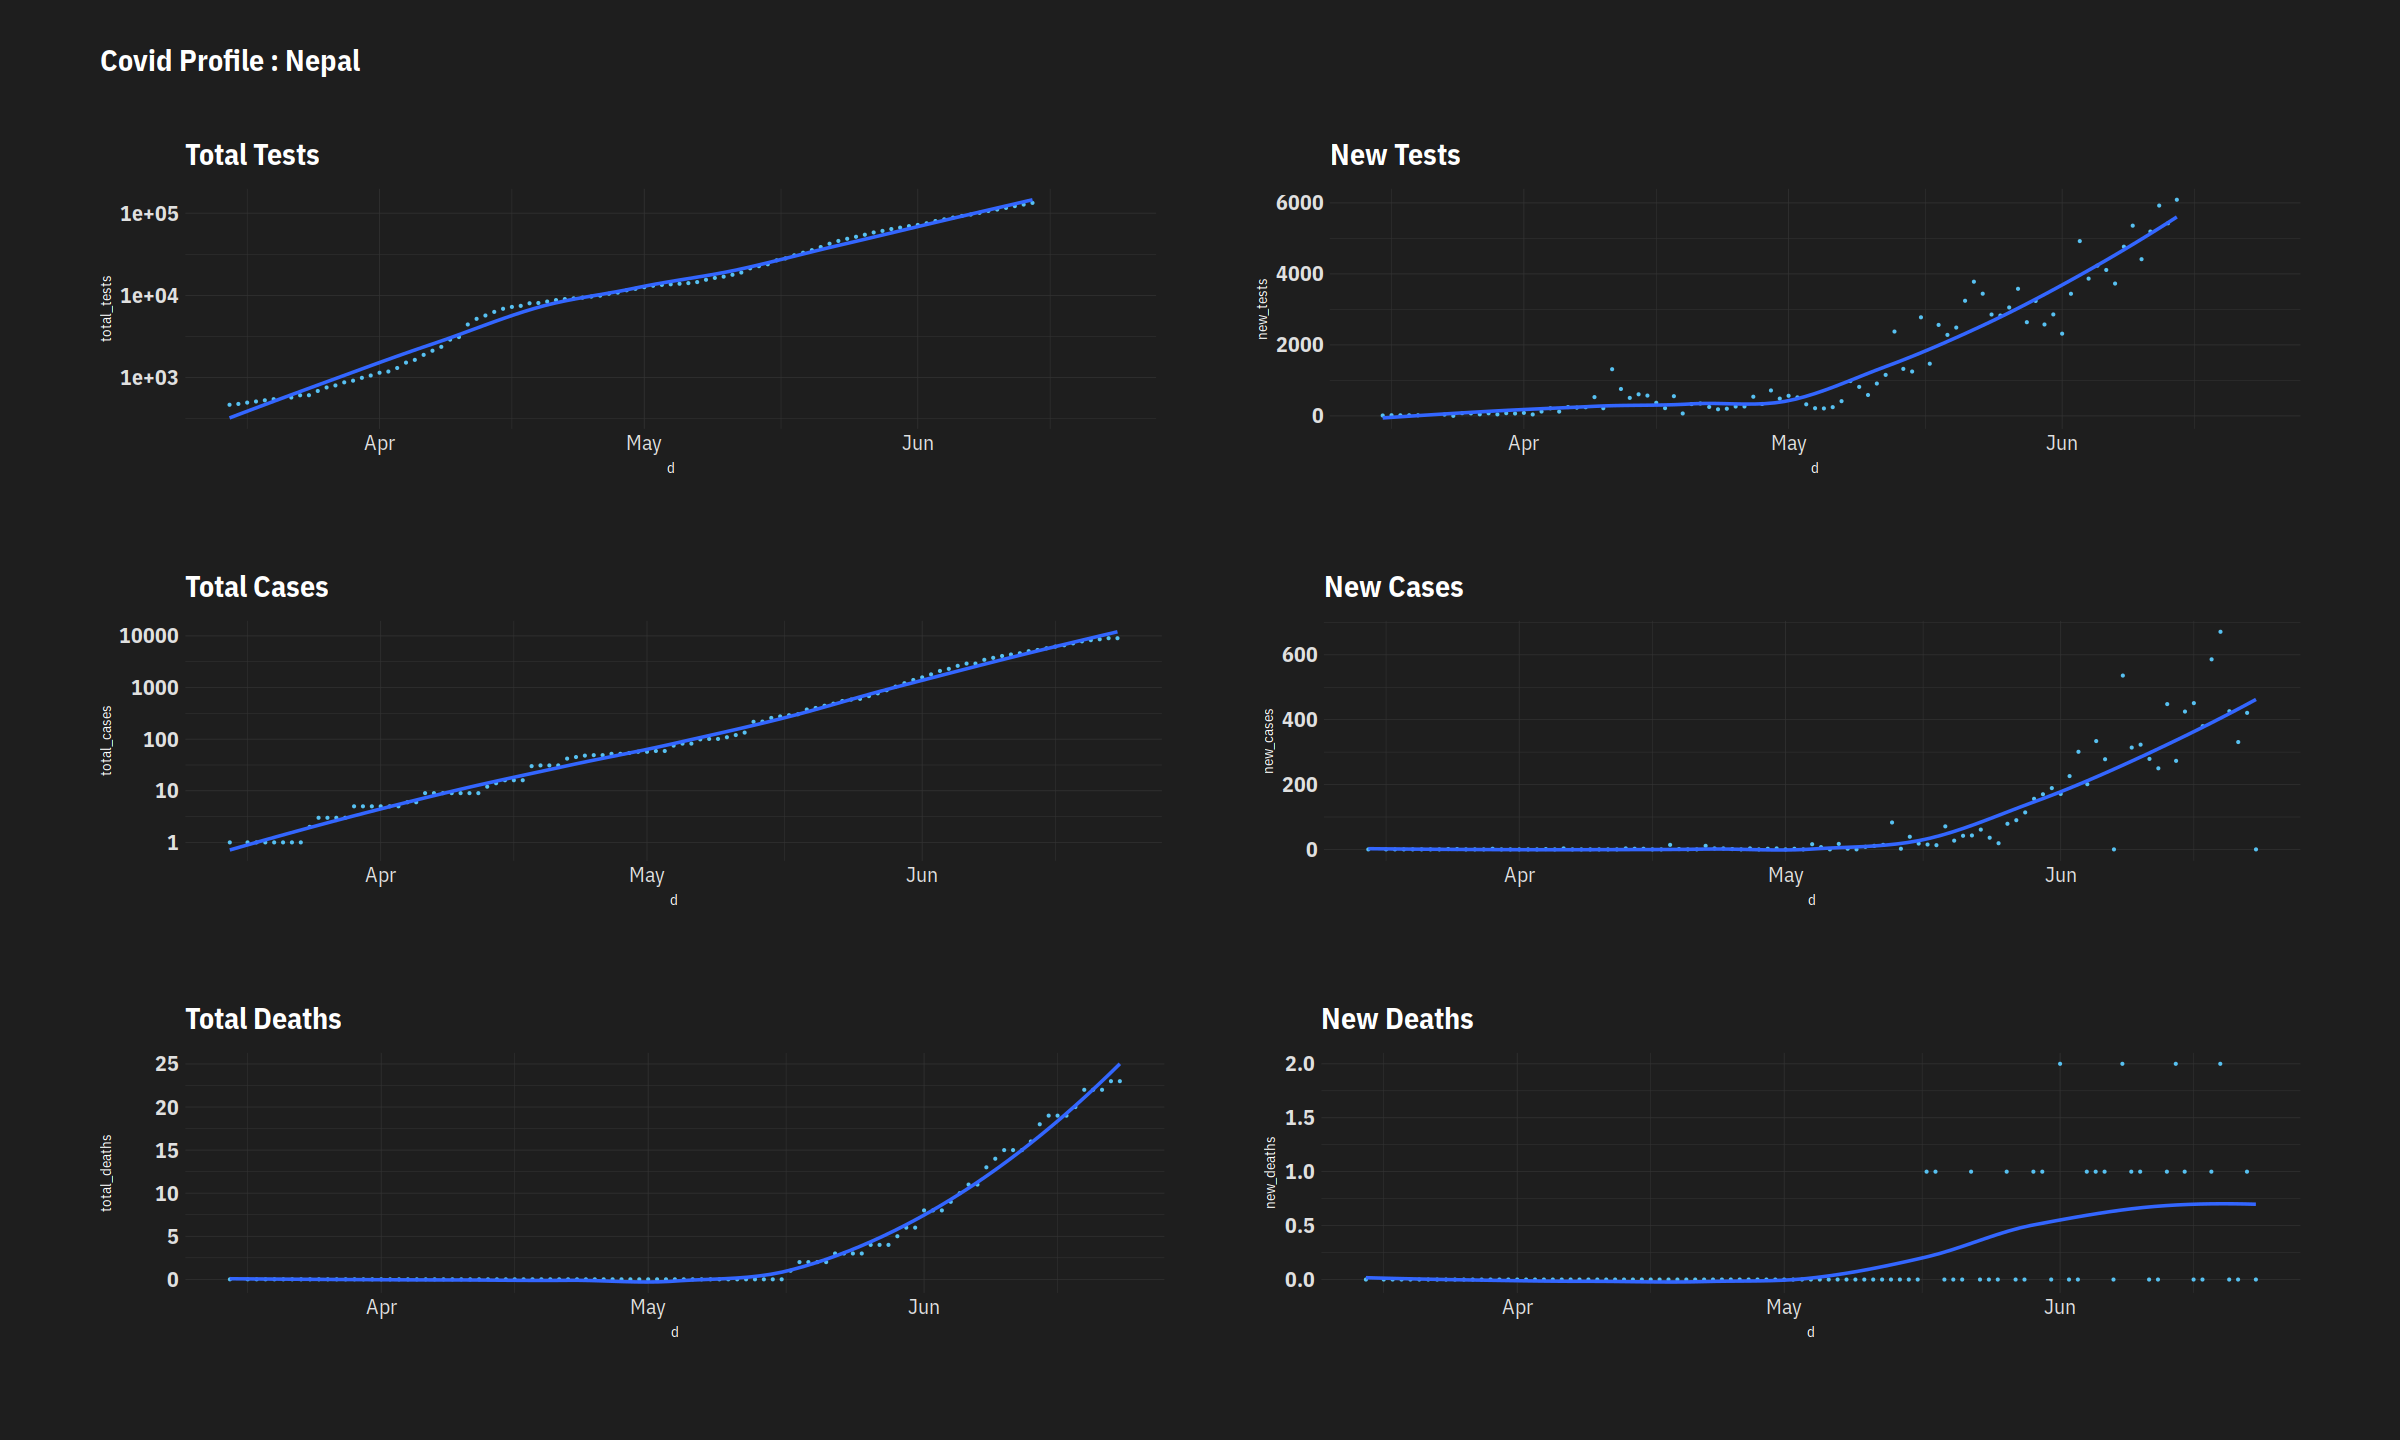

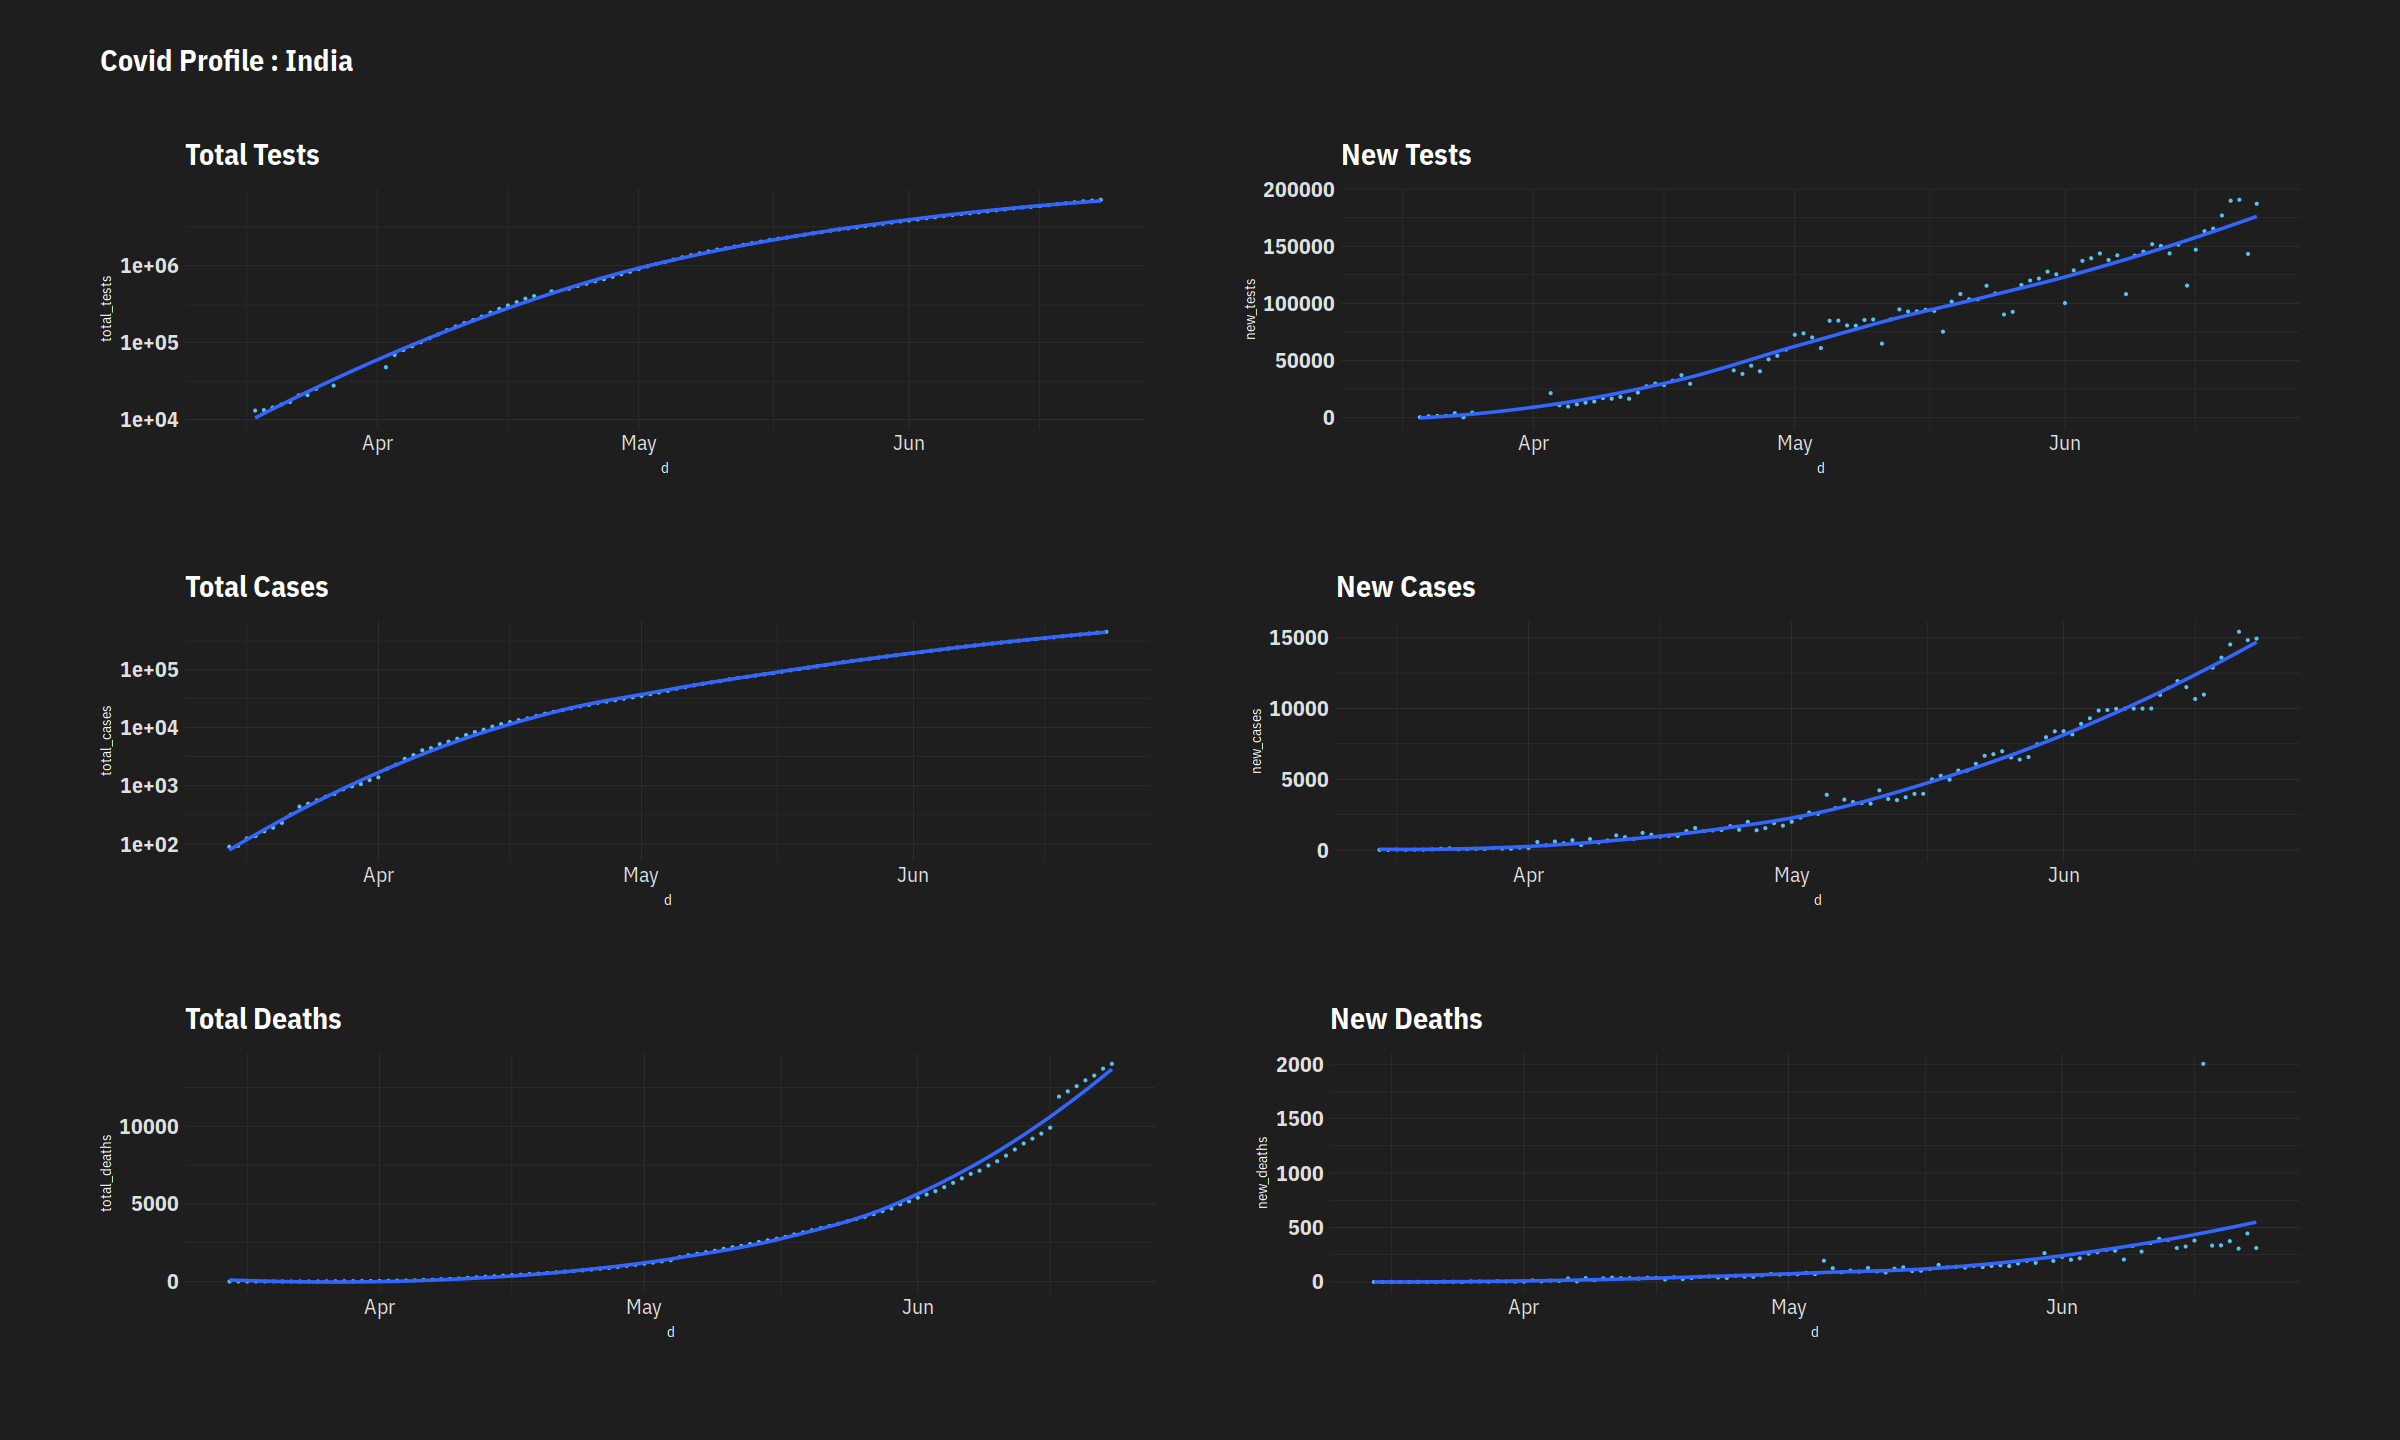

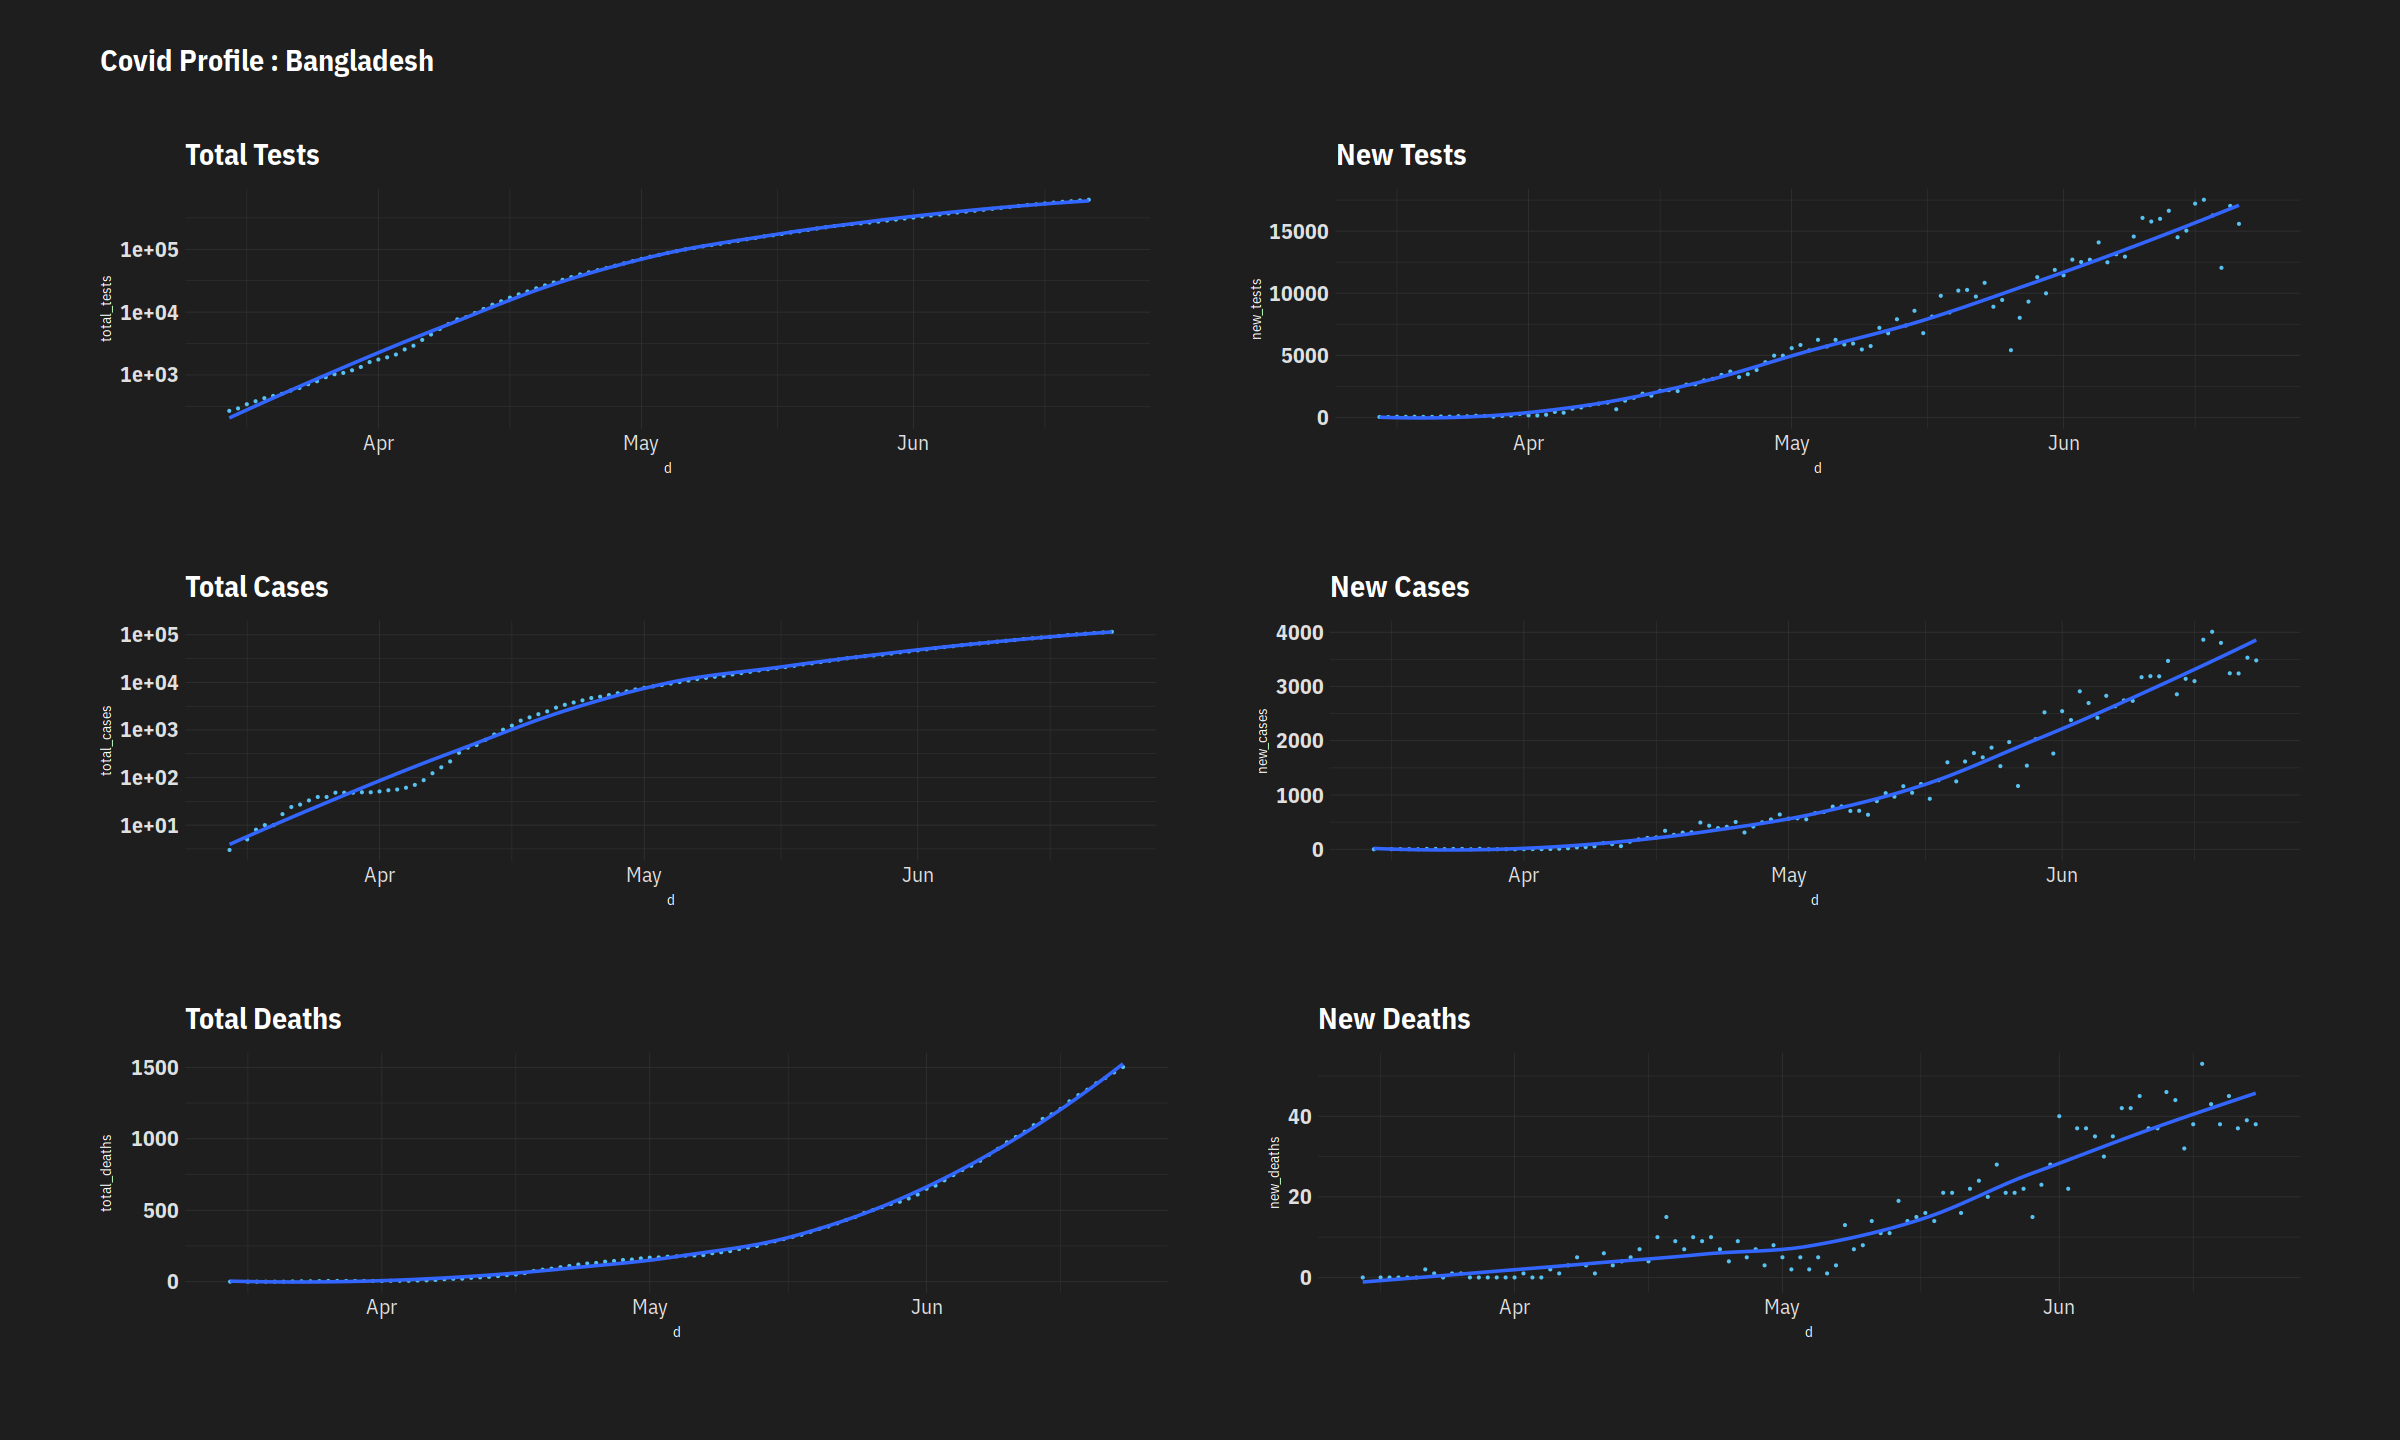

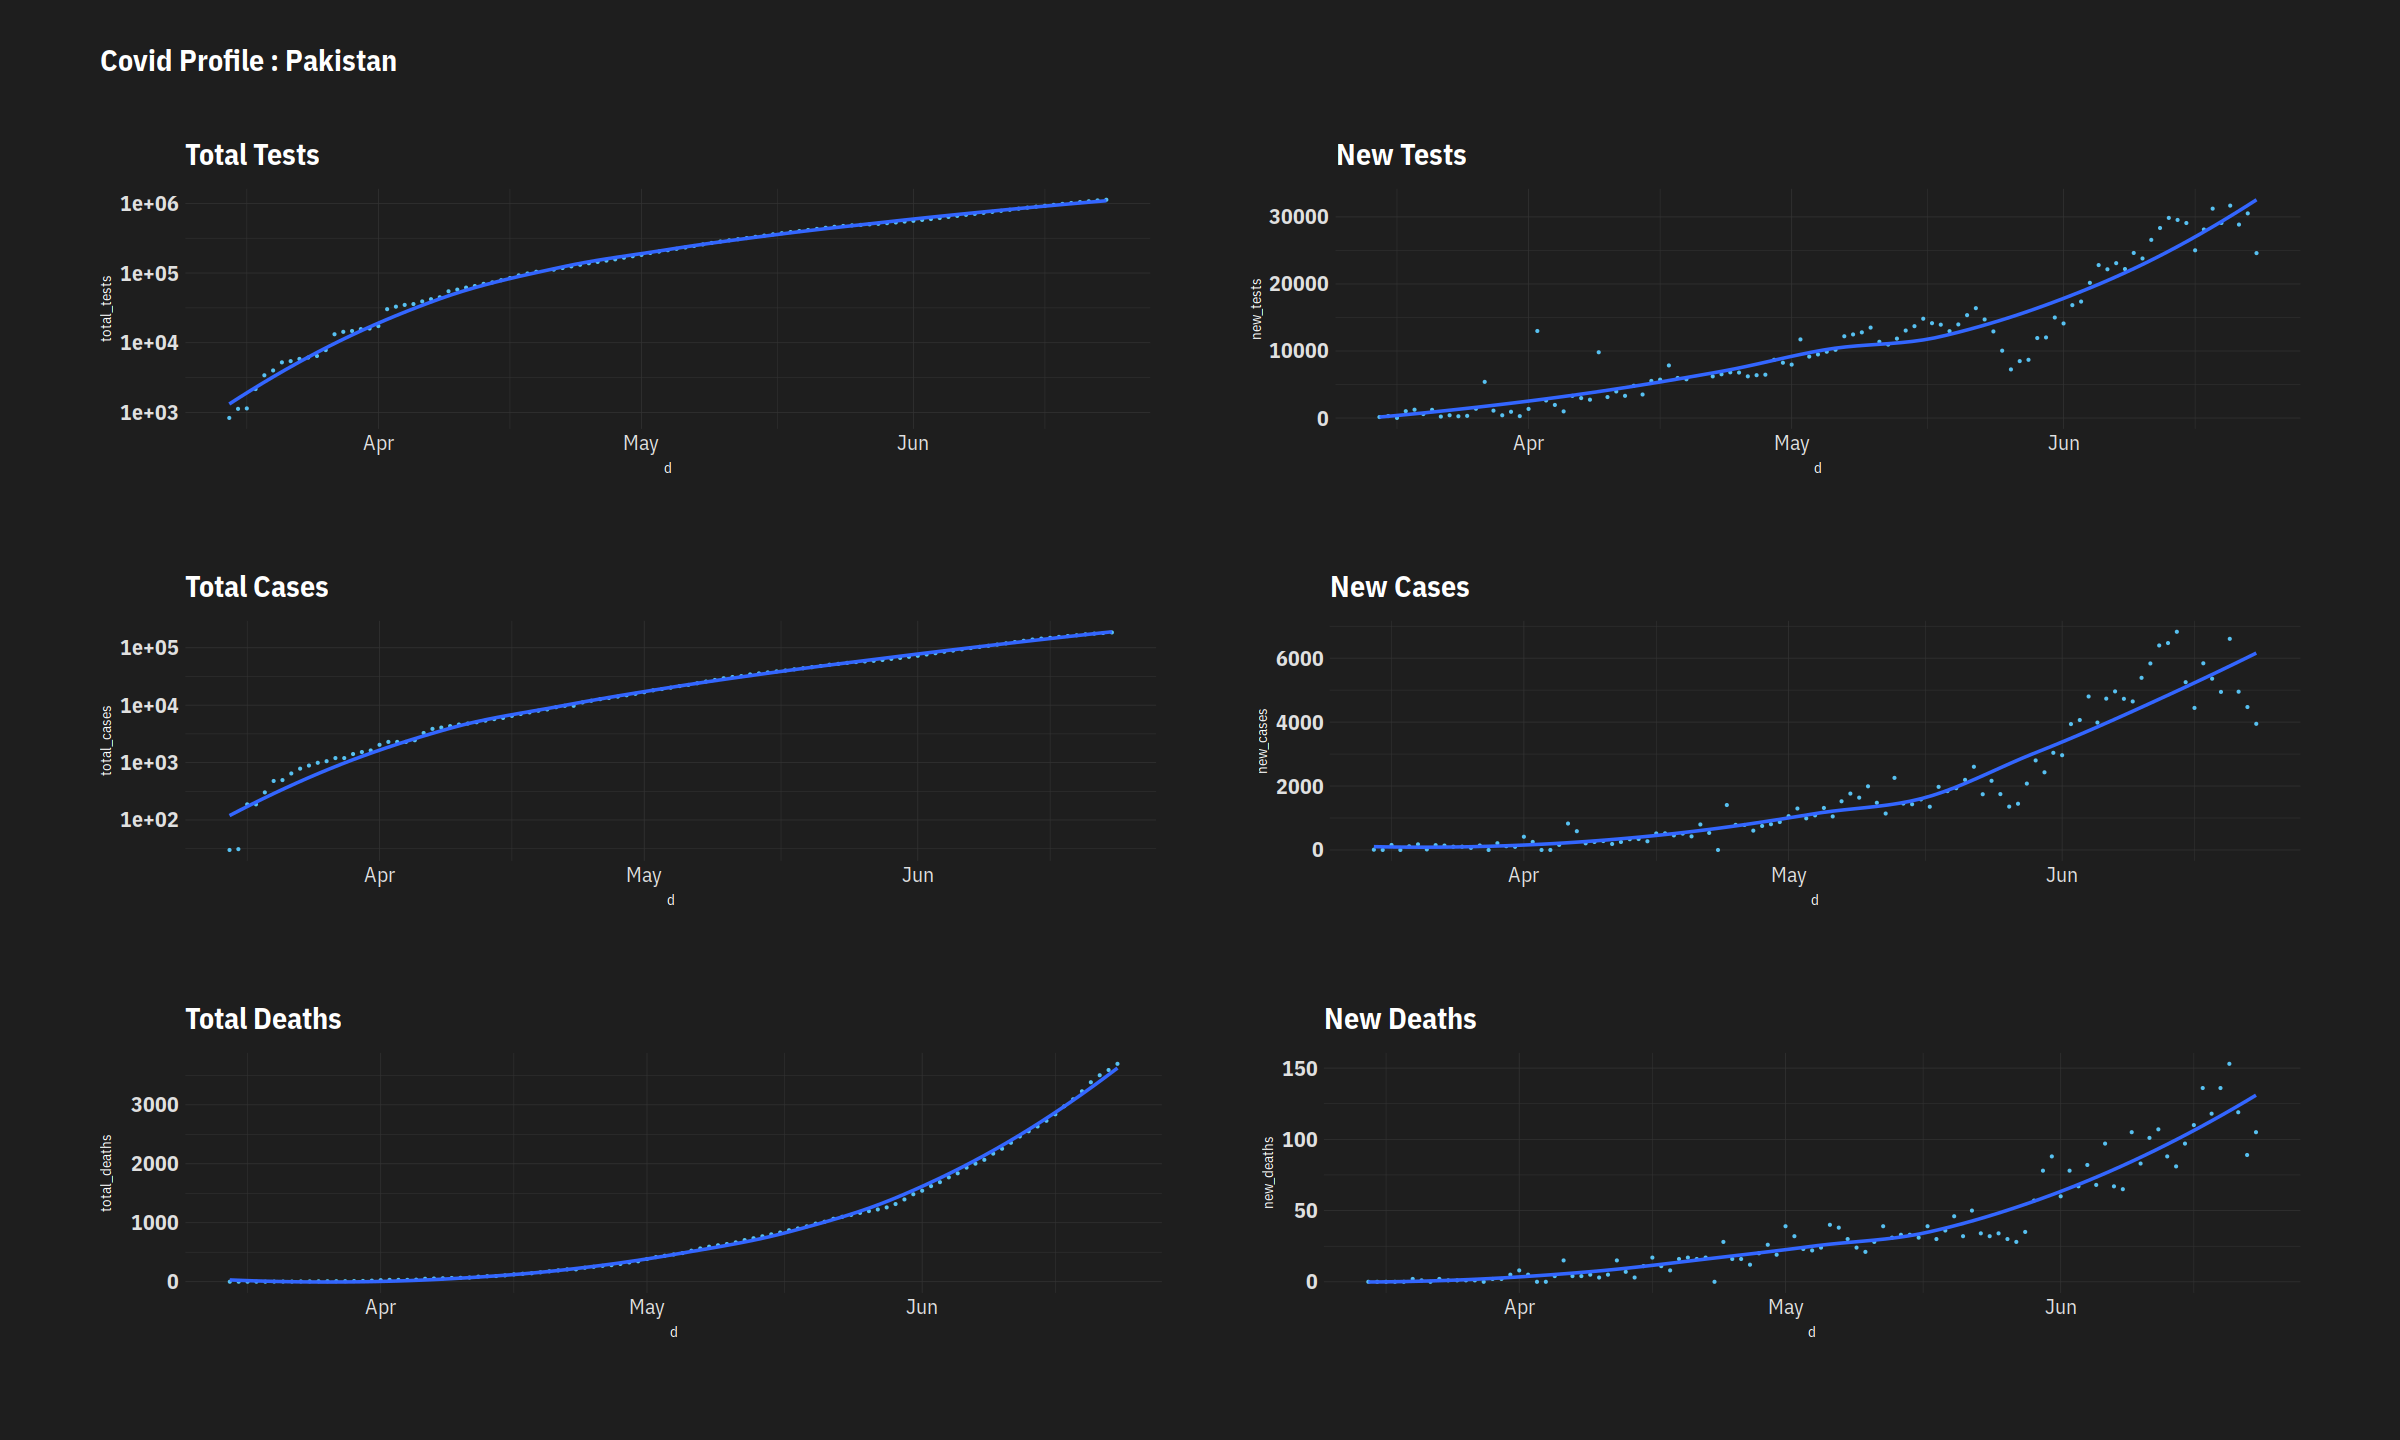

In [24]:
country_plot("Nepal") 
country_plot("India")
country_plot("Bangladesh")
country_plot("Pakistan")

## Sub-Saharan Africa

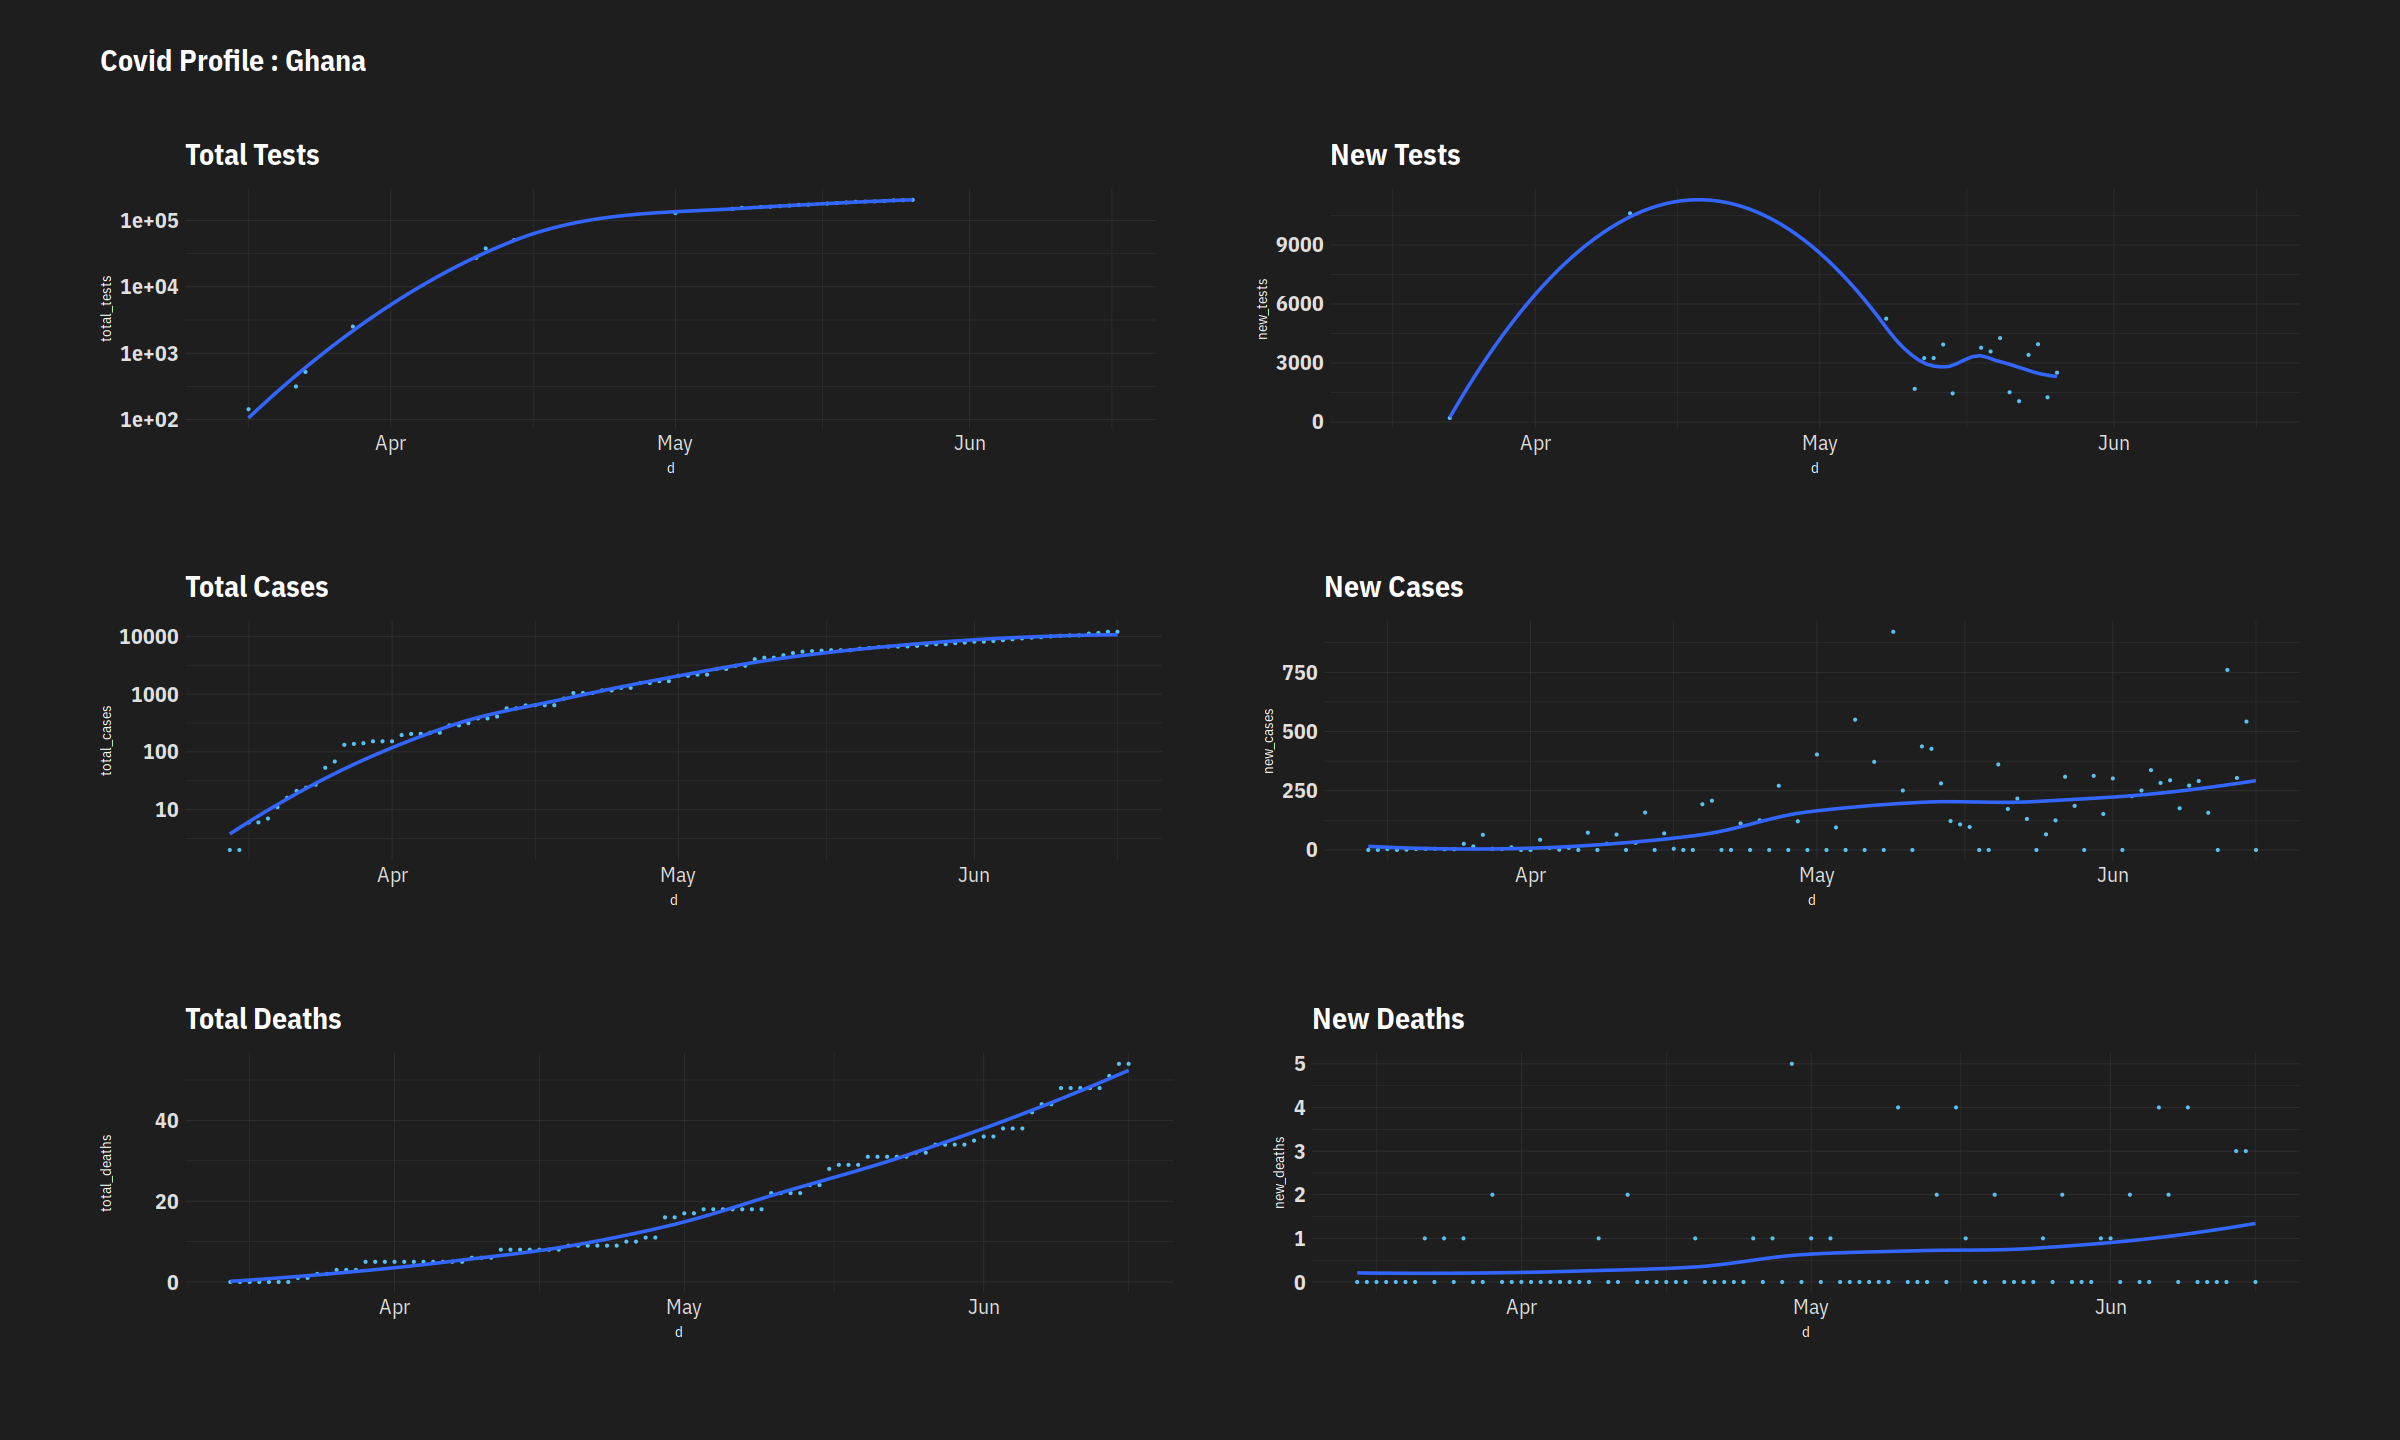

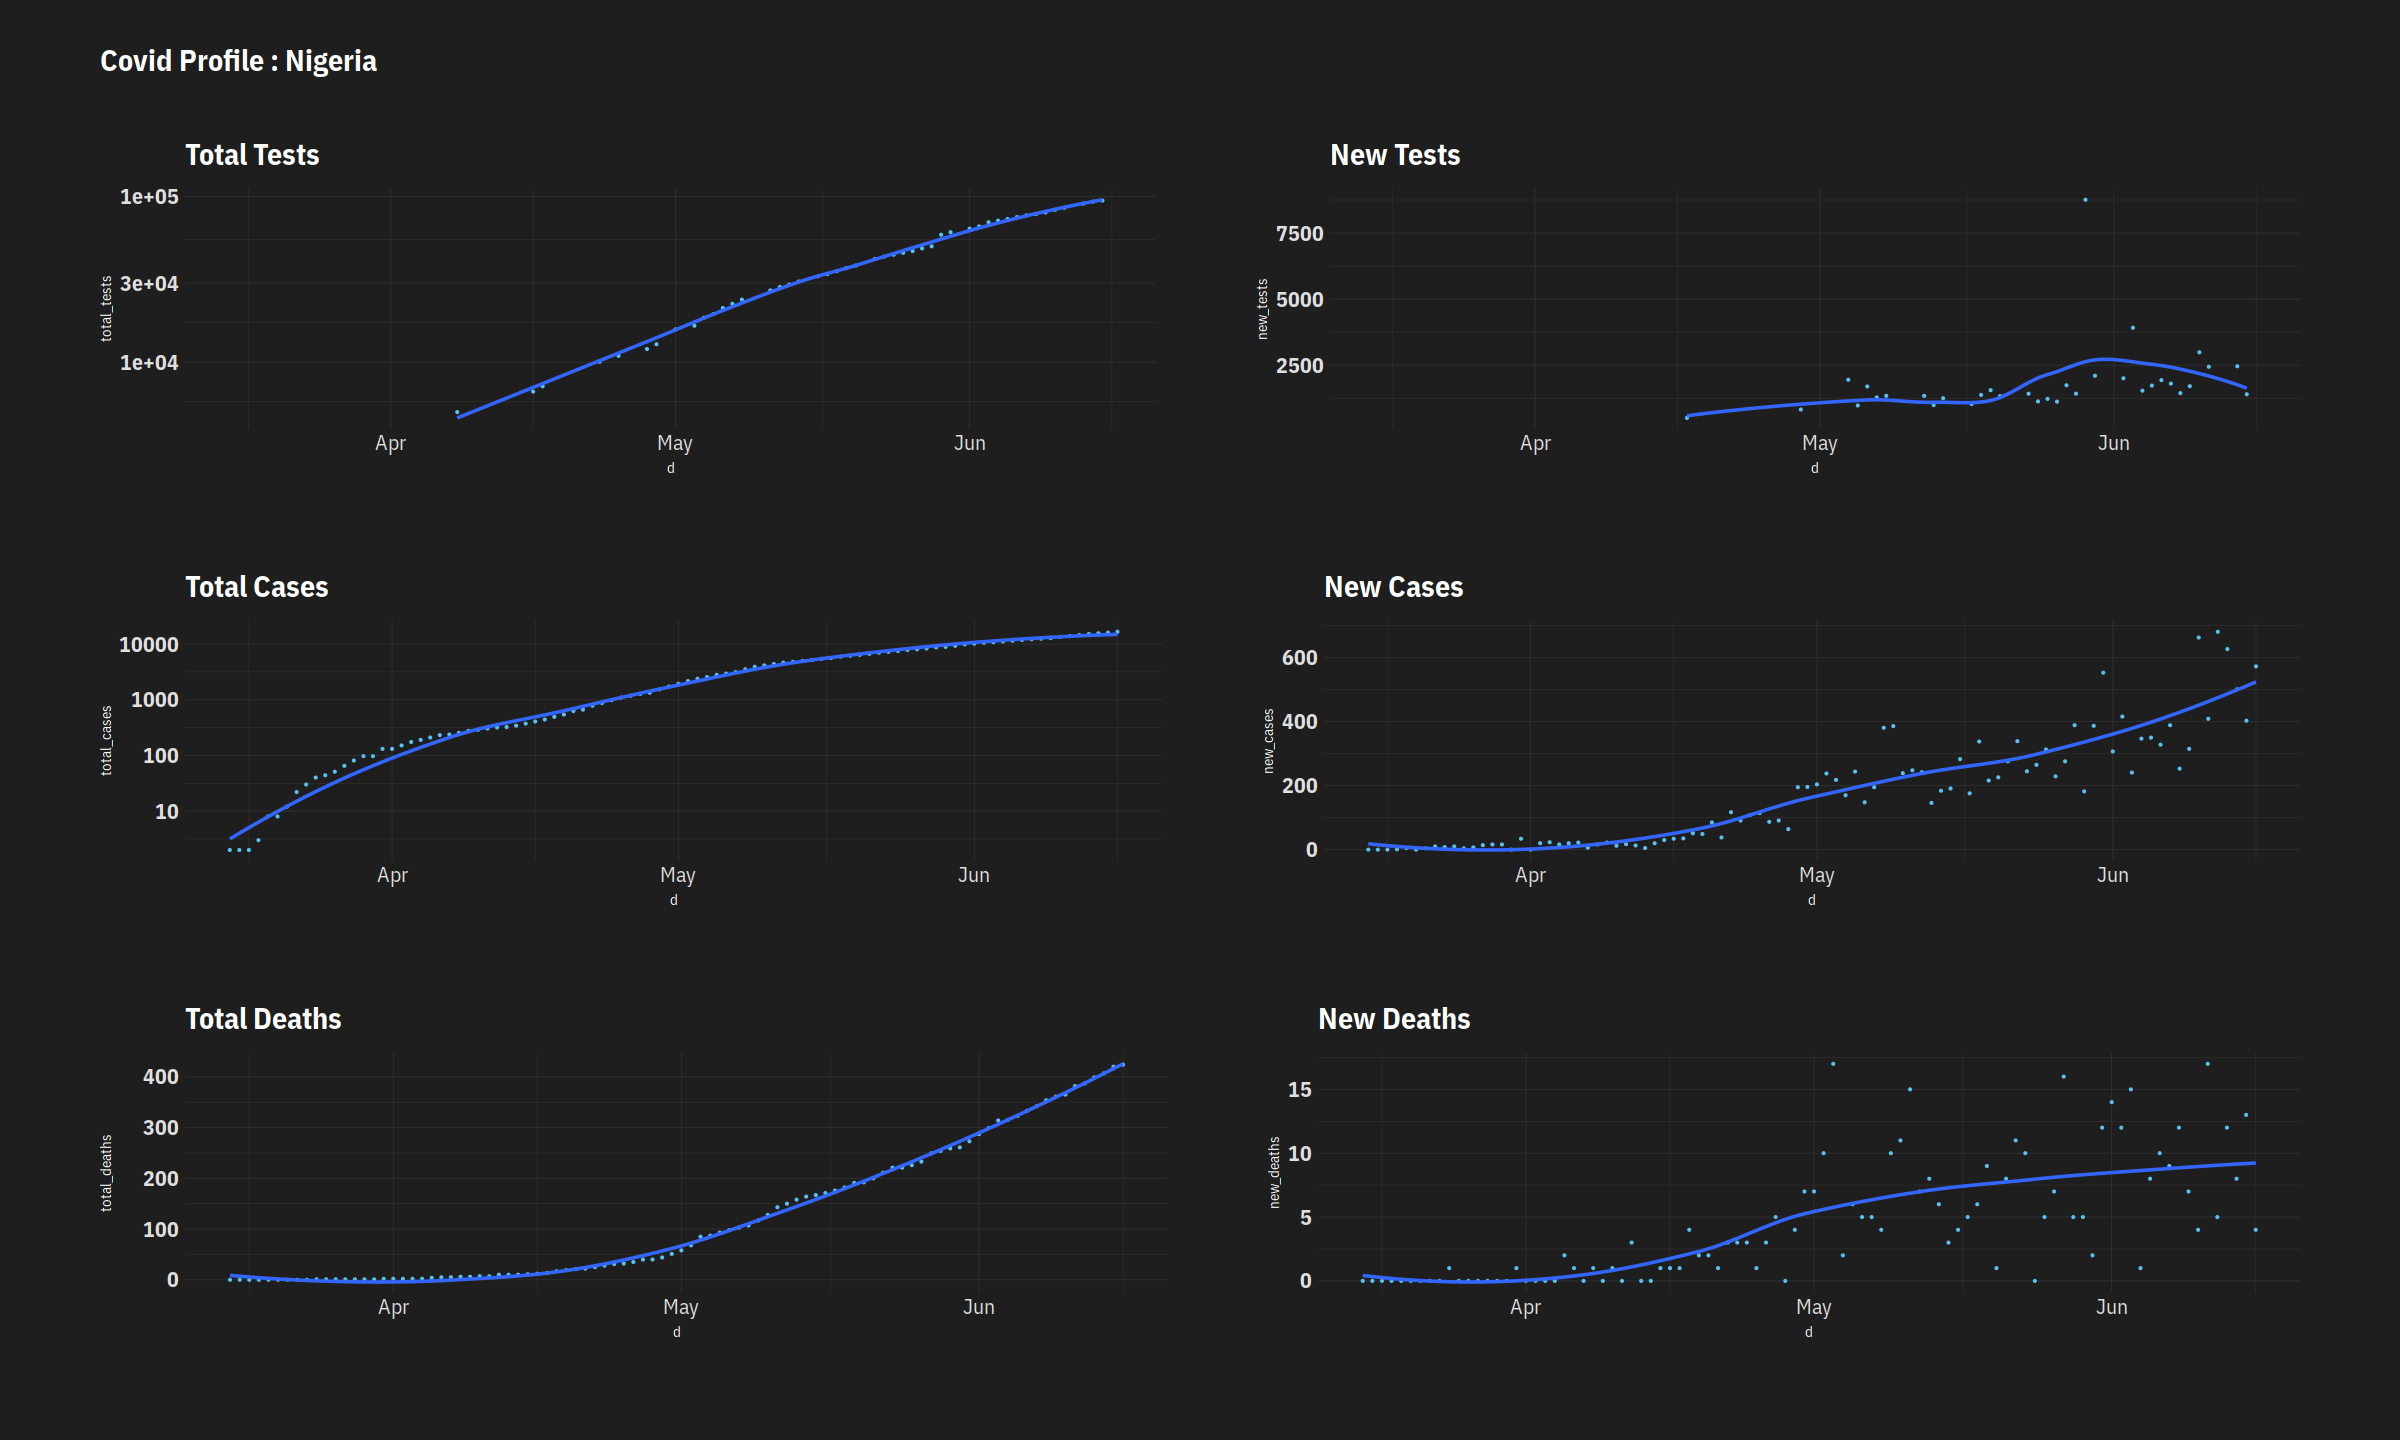

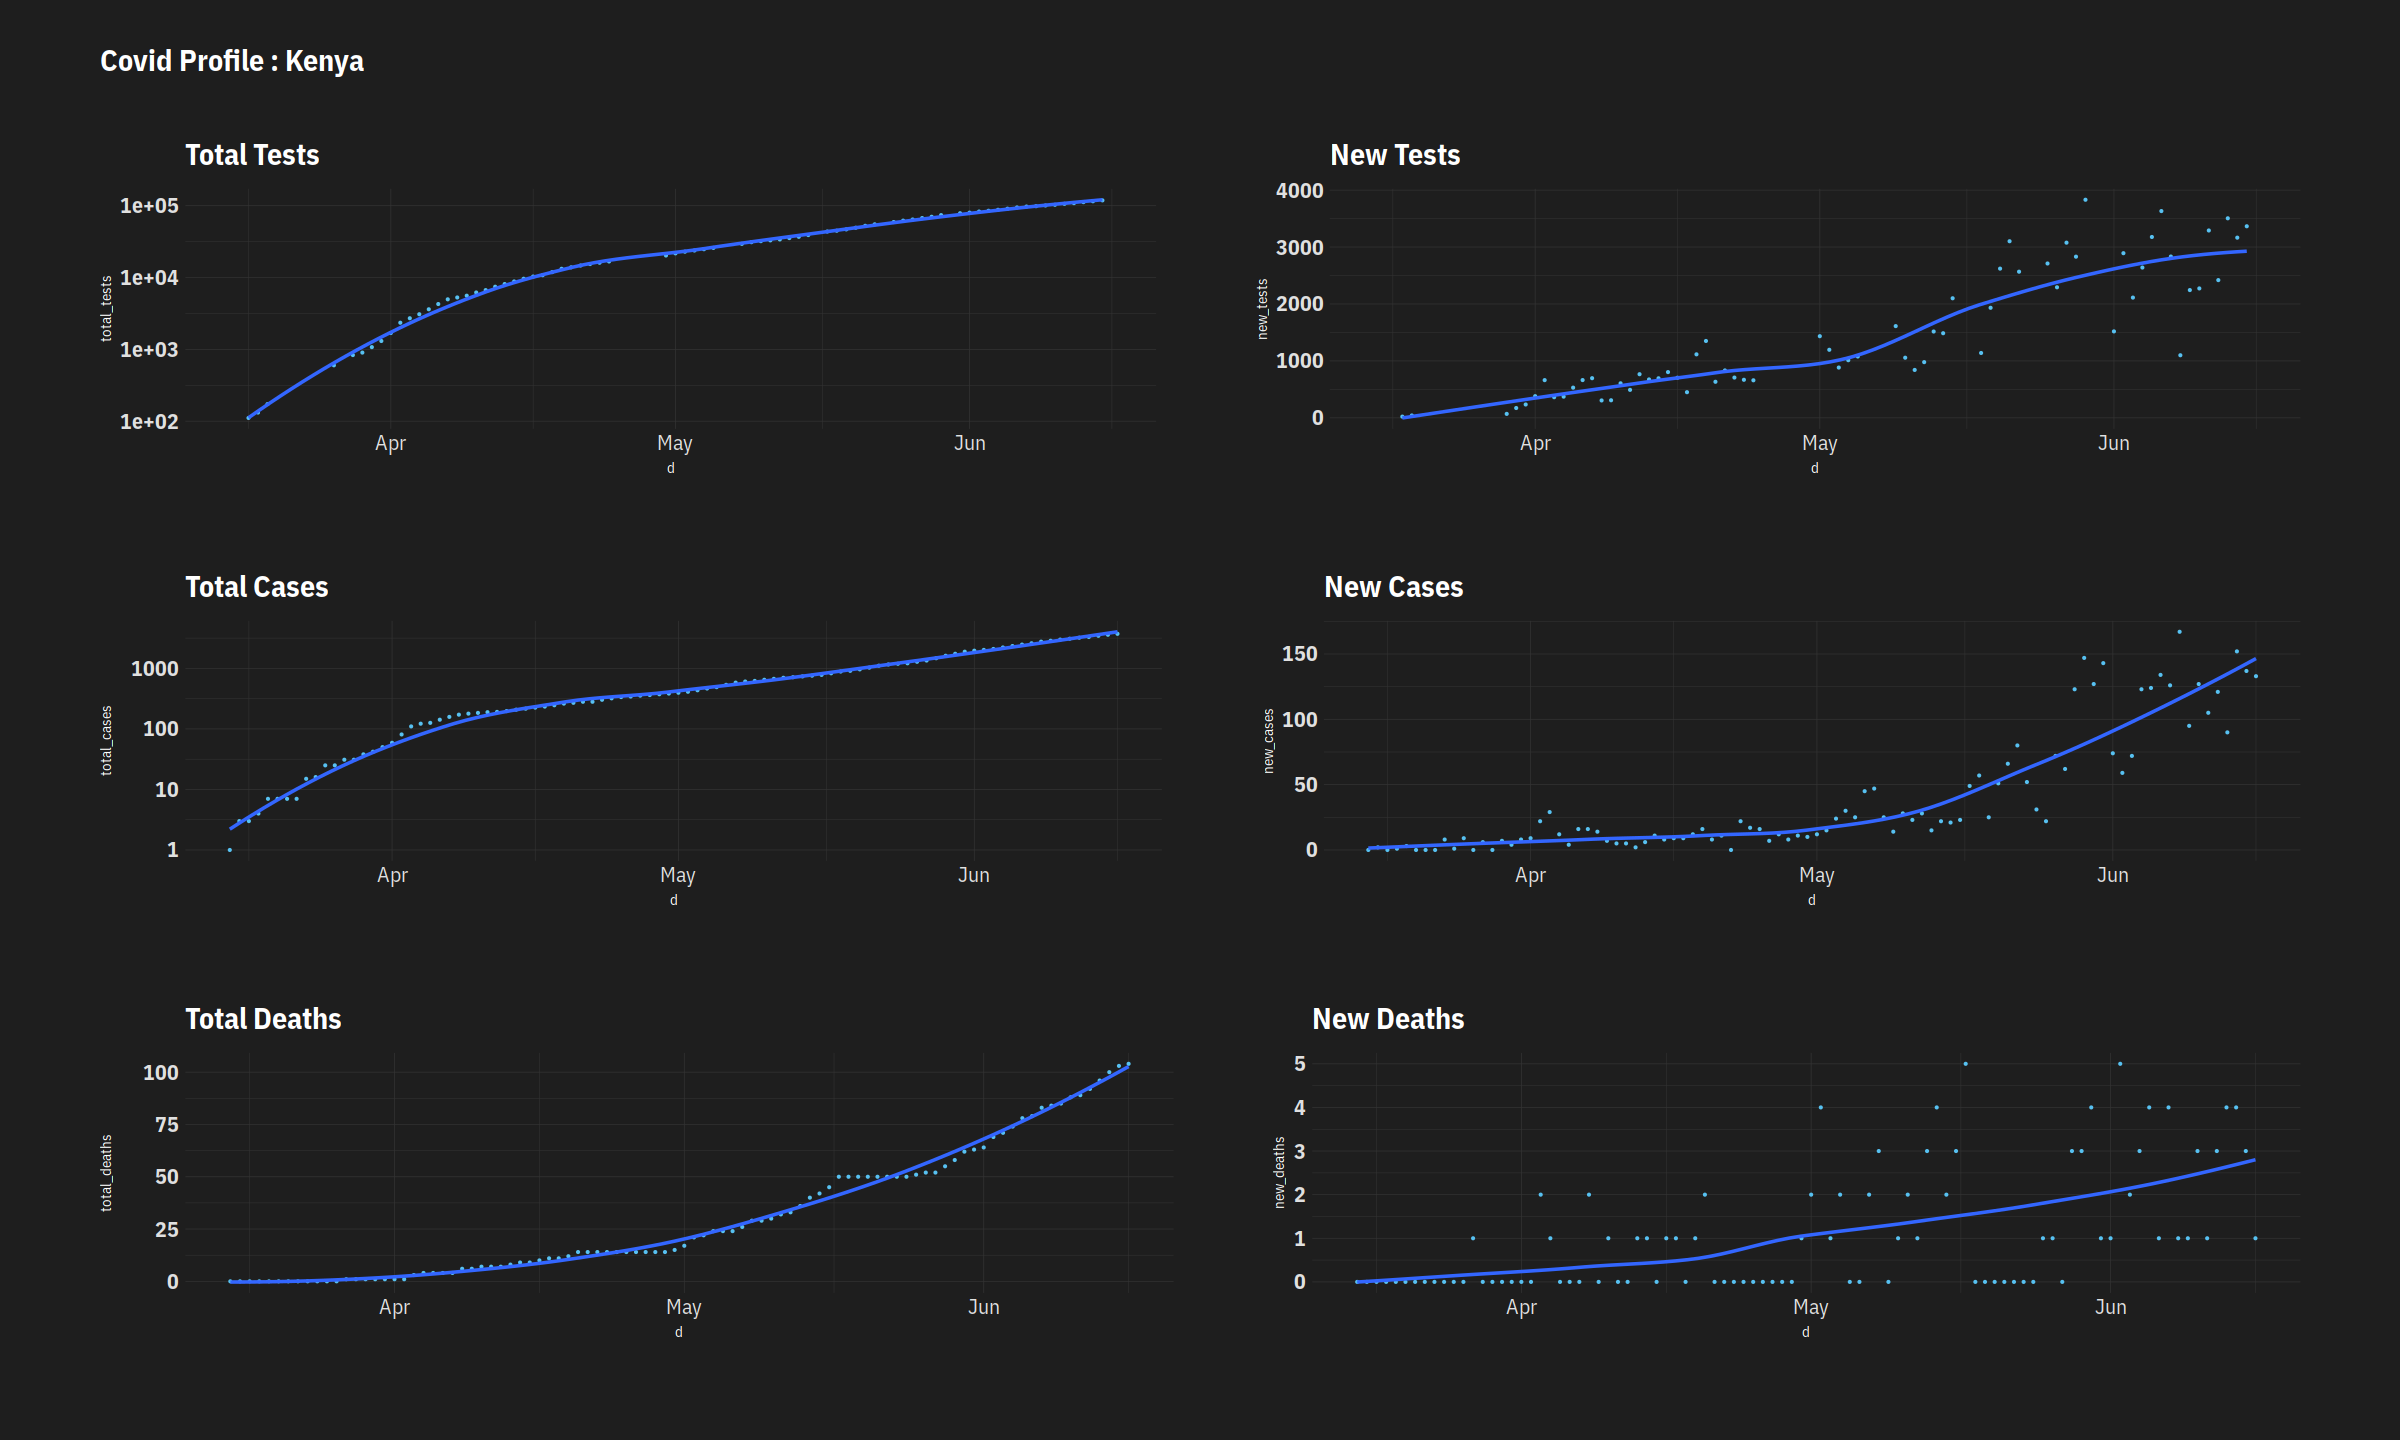

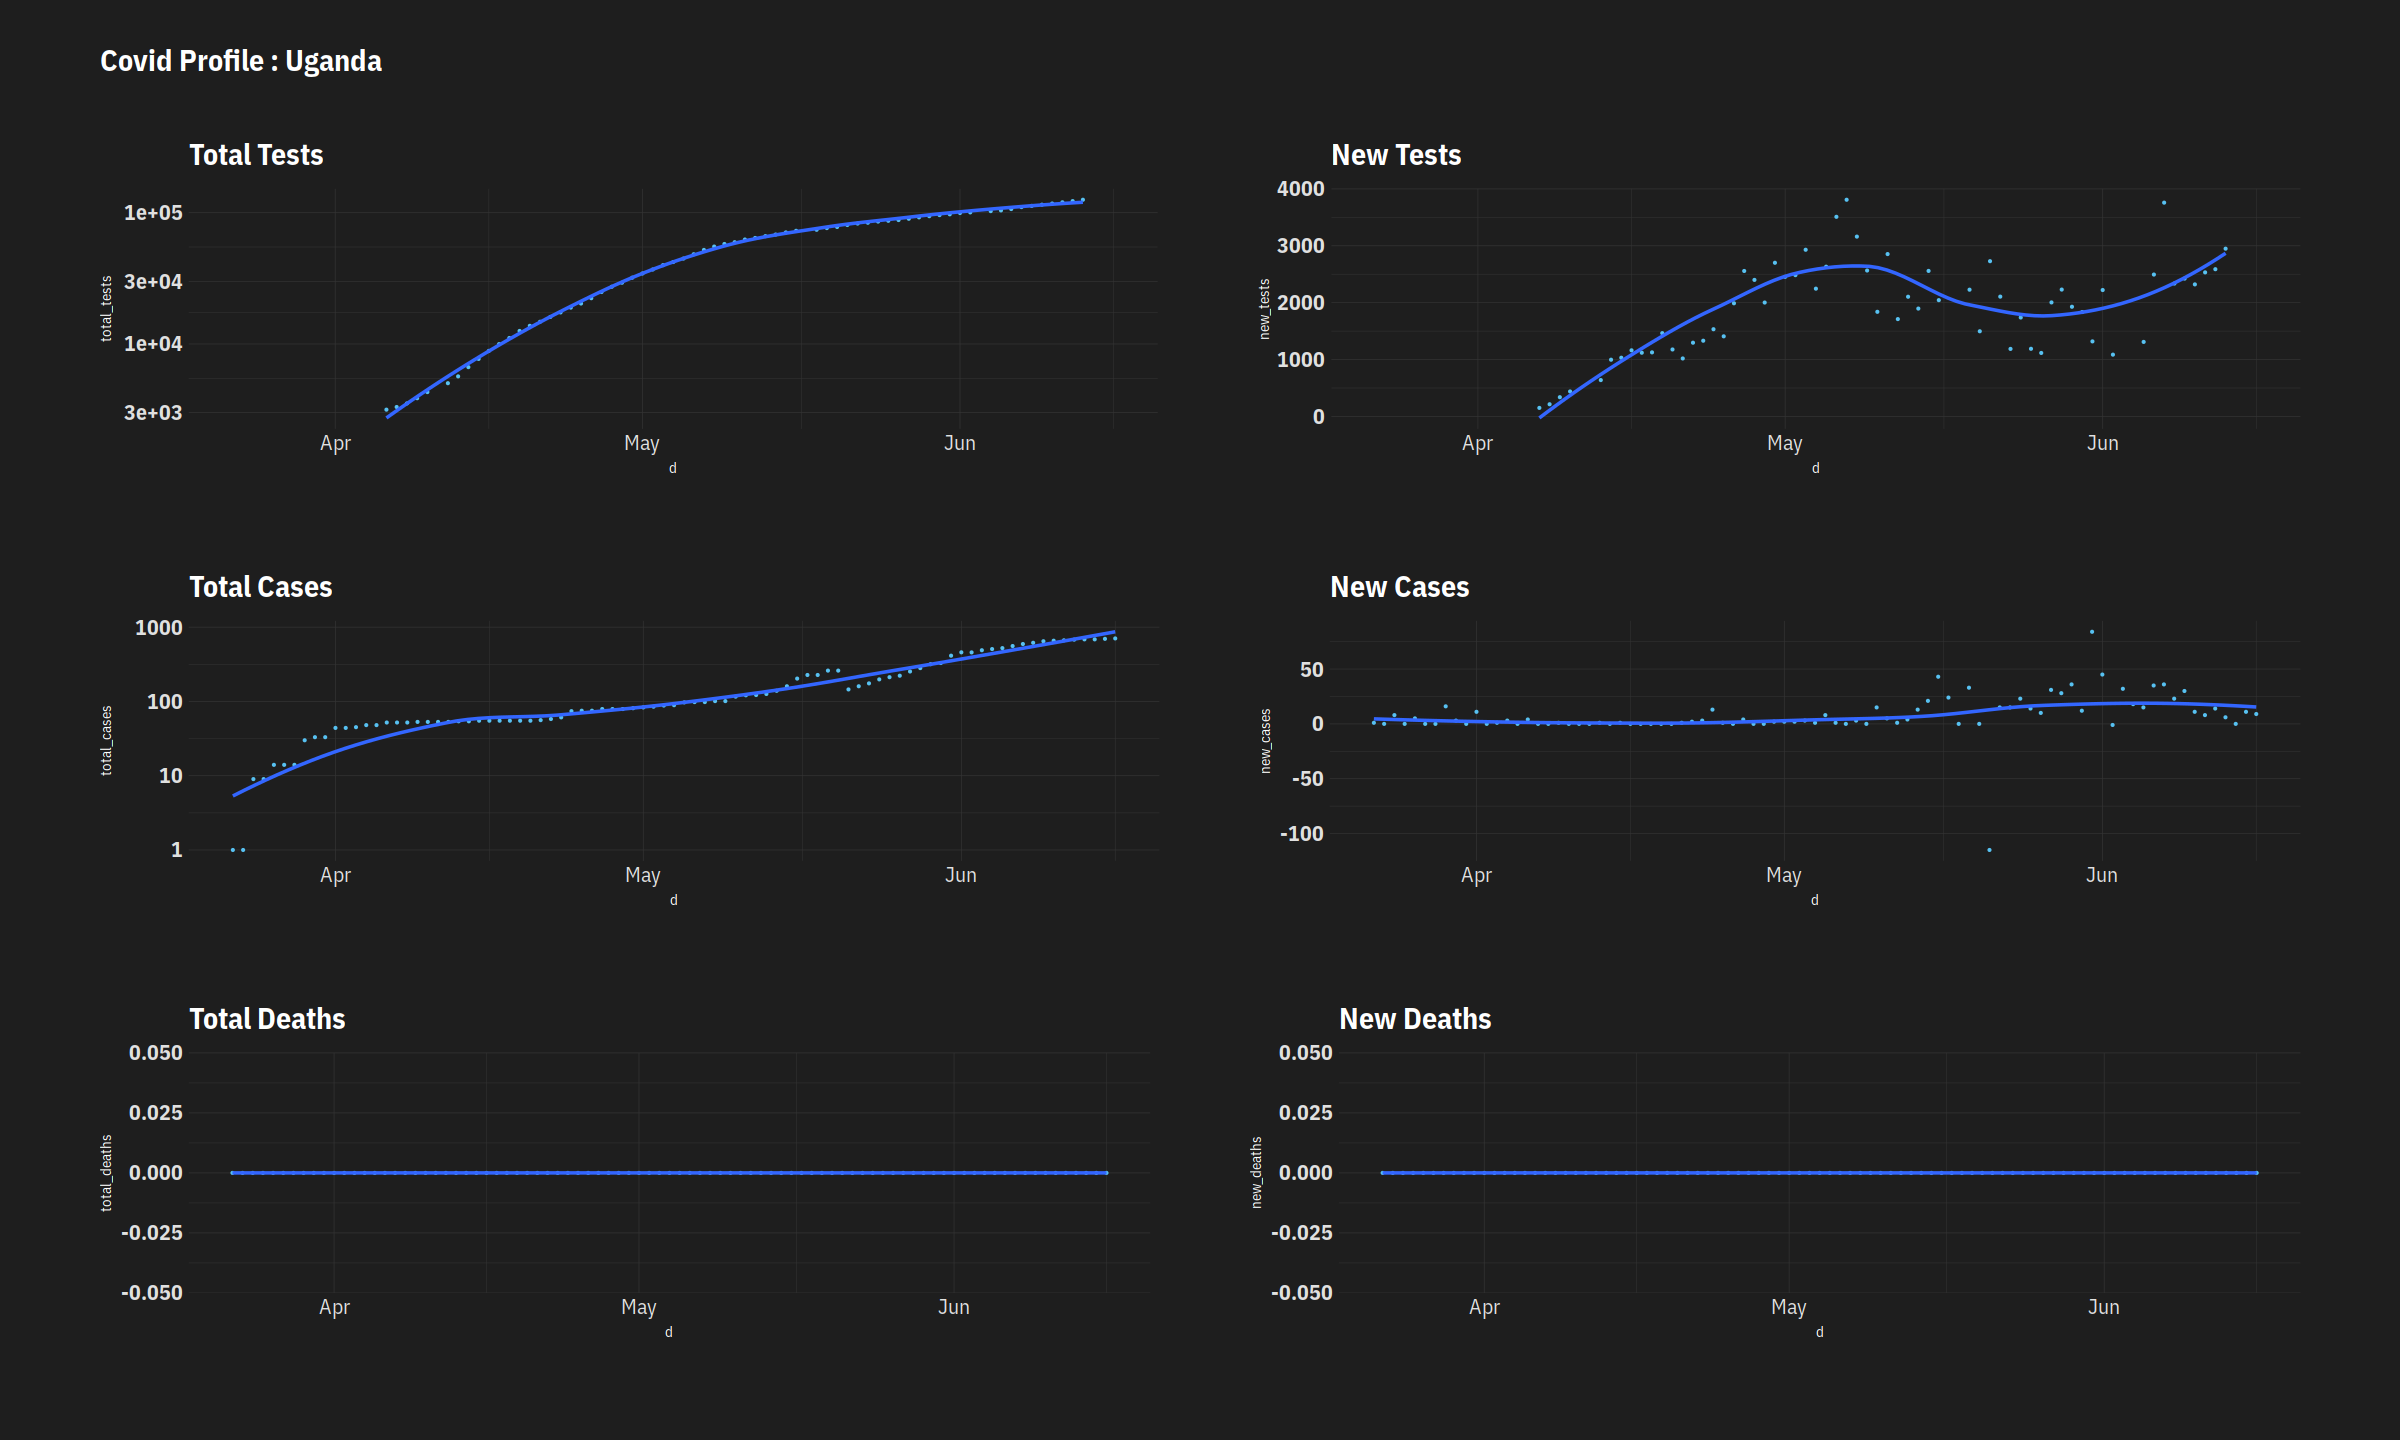

In [24]:
country_plot("Ghana")
country_plot("Nigeria")
country_plot("Kenya")
country_plot("Uganda")

## Eastern Europe

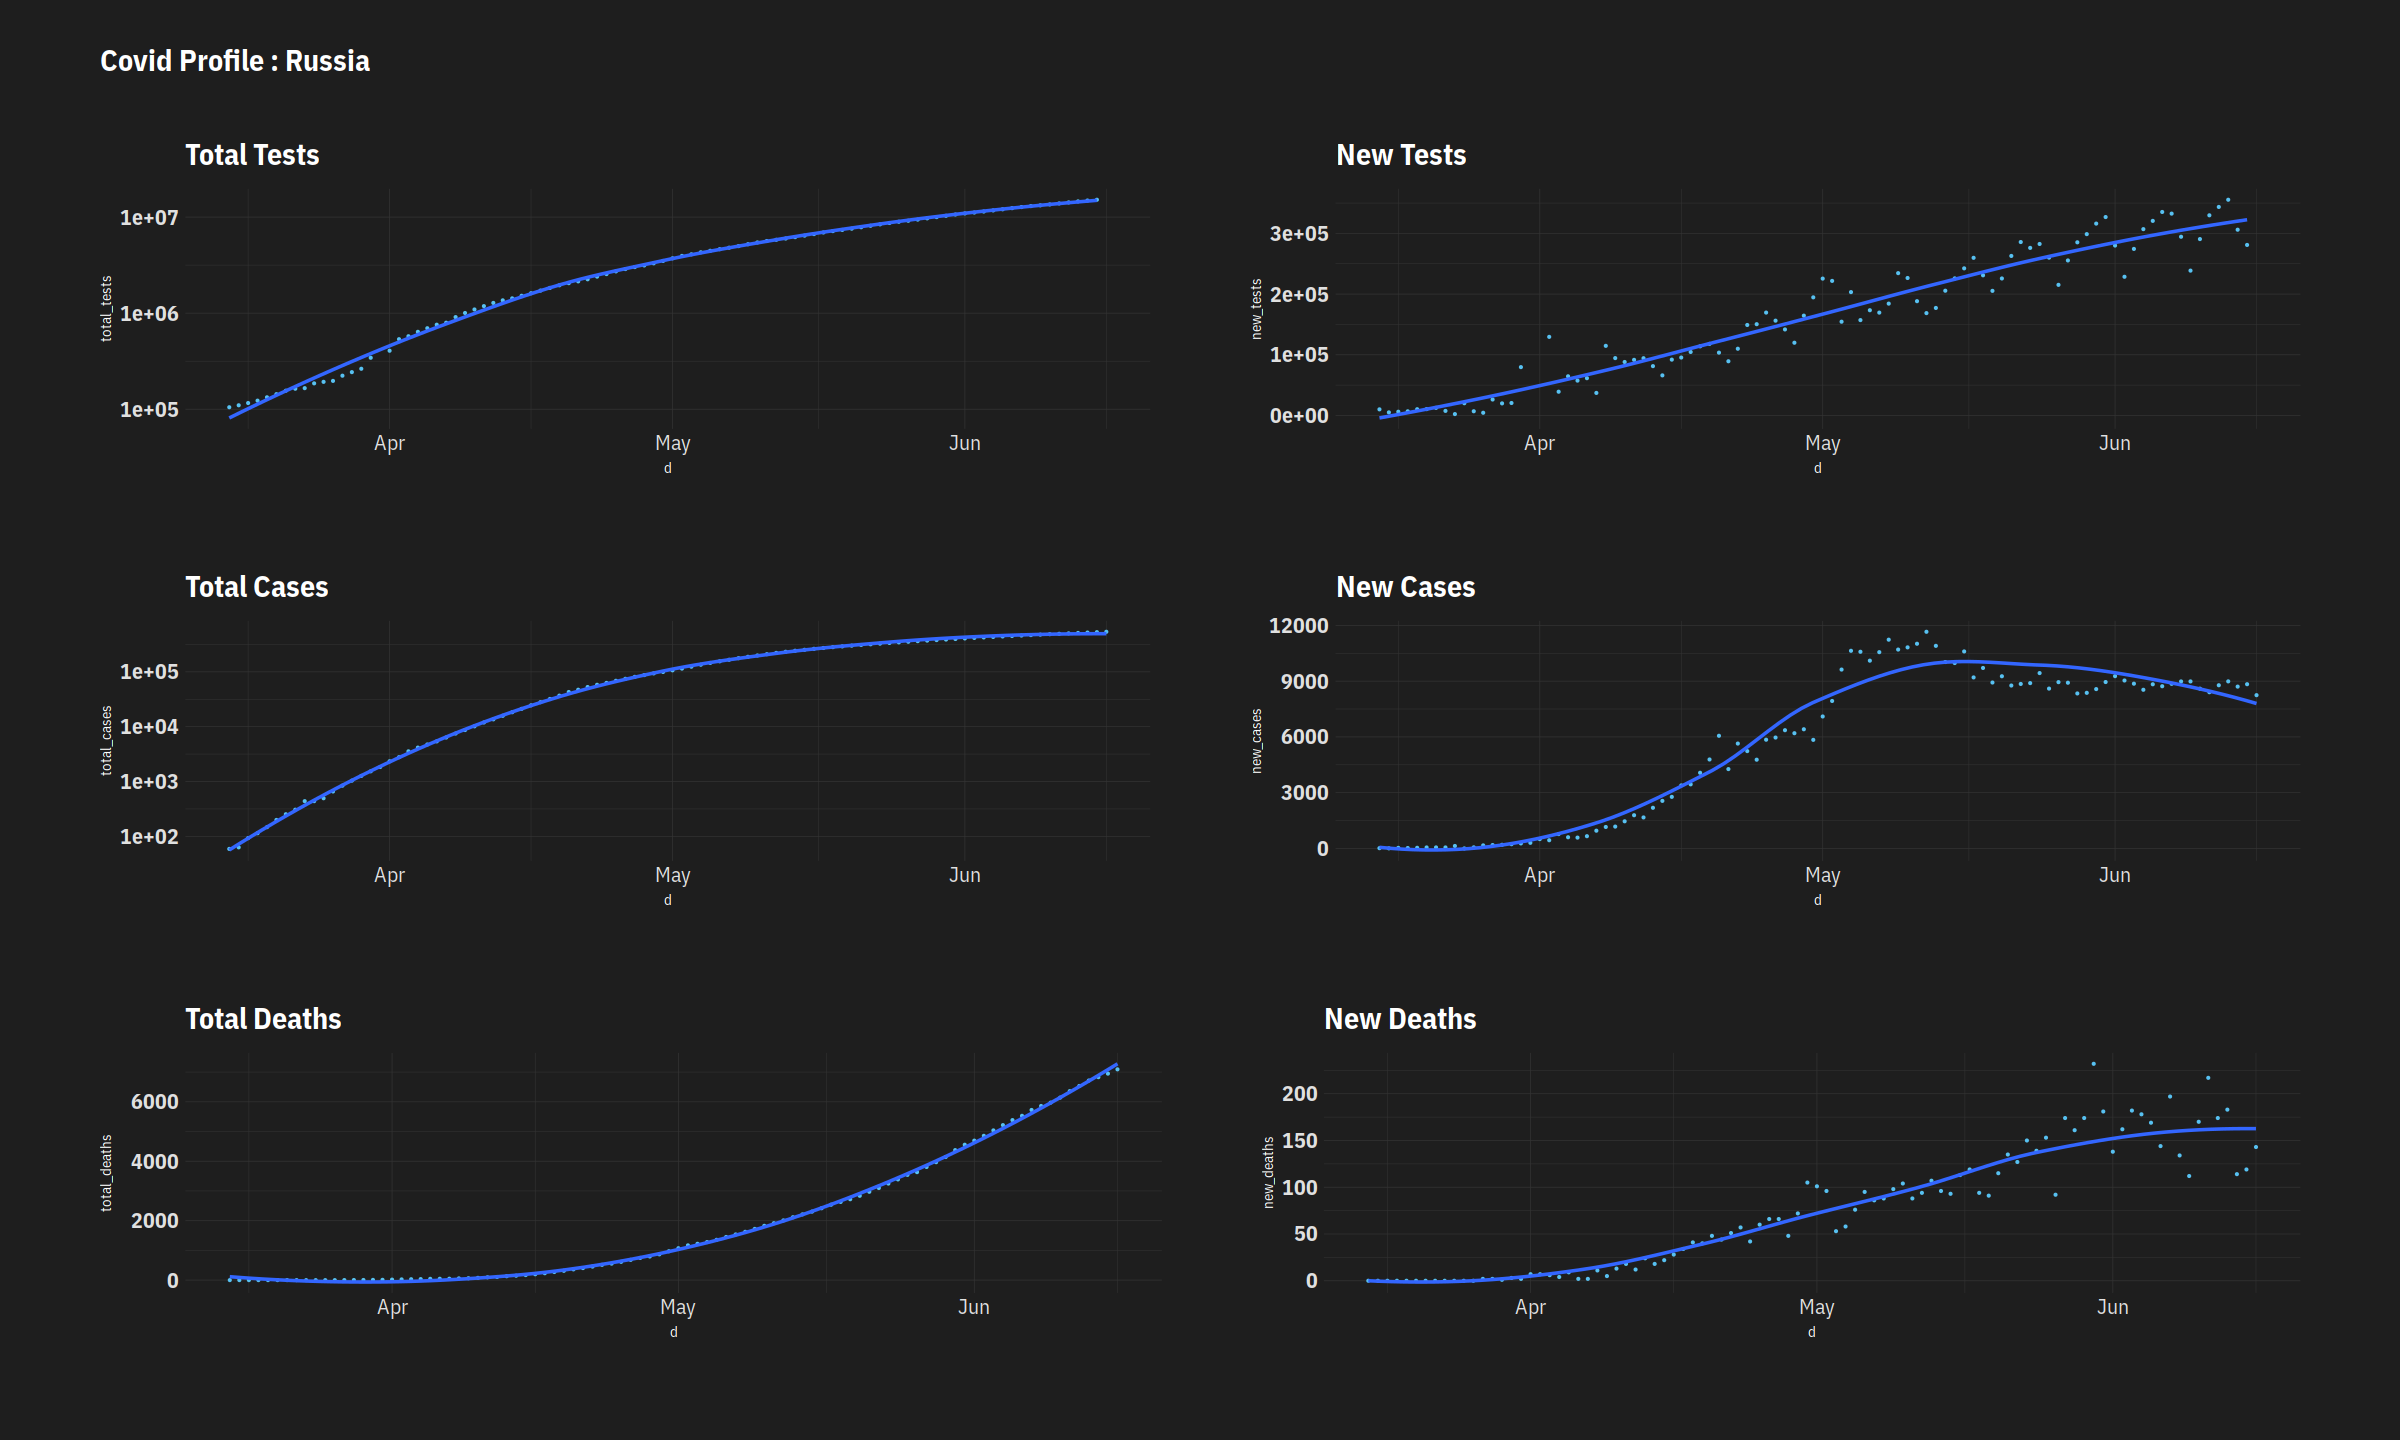

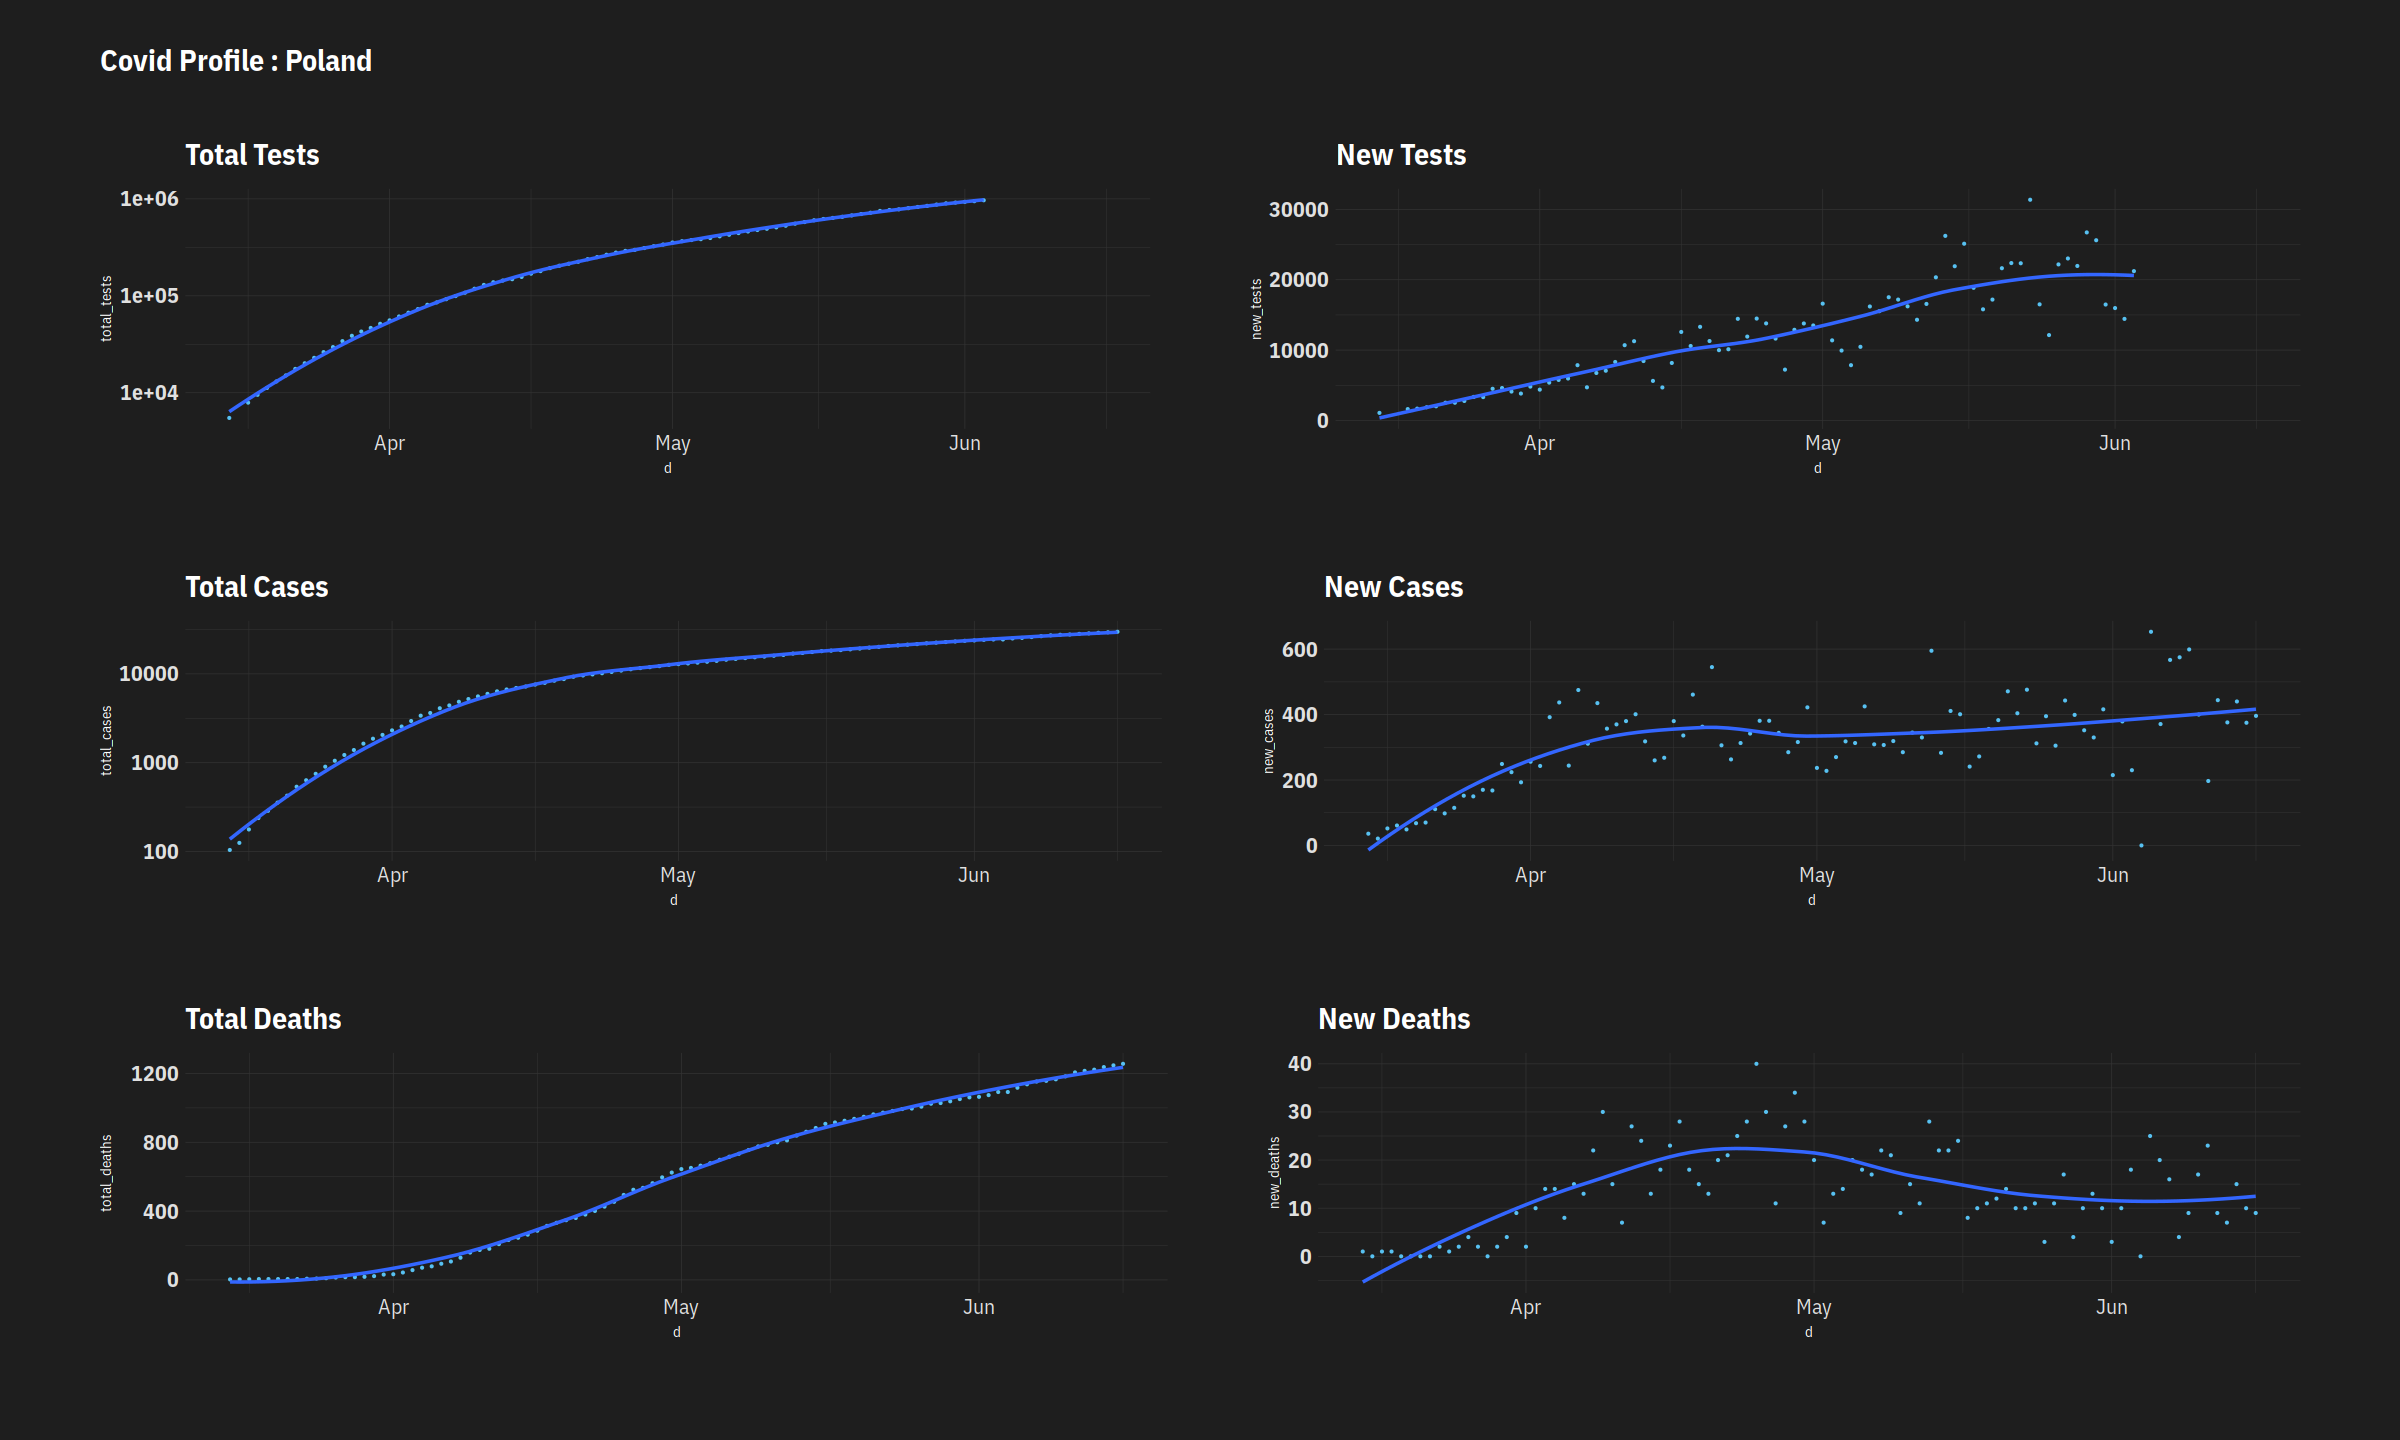

In [25]:
country_plot("Russia")
country_plot("Poland")

# Excess Mortality

In [25]:
exmort_nyt = fread("https://raw.githubusercontent.com/nytimes/covid-19-data/master/excess-deaths/deaths.csv")
exmort_nyt[, `:=`(
             start_date = ymd(start_date),
             end_date   = ymd(start_date),
             year = as.numeric(year)
           )
           ]
exmort_nyt %>% glimpse

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”


Rows: 6,498
Columns: 12
$ country         <chr> "Austria", "Austria", "Austria", "Austria", "Austria"…
$ placename       <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", "…
$ frequency       <chr> "weekly", "weekly", "weekly", "weekly", "weekly", "we…
$ start_date      <date> 2020-01-06, 2020-01-13, 2020-01-20, 2020-01-27, 2020…
$ end_date        <date> 2020-01-06, 2020-01-13, 2020-01-20, 2020-01-27, 2020…
$ year            <dbl> 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020,…
$ month           <int> 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,…
$ week            <int> 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1…
$ deaths          <int> 1702, 1797, 1778, 1947, 1678, 1721, 1715, 1768, 1743,…
$ expected_deaths <int> 1814, 1824, 1832, 1836, 1835, 1826, 1809, 1784, 1754,…
$ excess_deaths   <int> -112, -27, -54, 111, -157, -105, -94, -16, -11, -1, 1…
$ baseline        <chr> "2015-2019 historical data", "2015-2019 historical da…


In [26]:
exmort_nyt[, .N, by = .(country, placename, frequency)]

country        placename      frequency N  
1  Austria                       weekly    270
2  Belgium                       weekly    218
3  Brazil         Fortaleza      weekly     85
4  Brazil         Manaus         weekly     85
5  Brazil         Recife         weekly     85
6  Brazil         Rio de Janeiro weekly     85
7  Brazil         Sao Paulo      weekly     85
8  Chile                         monthly    53
9  Denmark                       weekly    271
10 Ecuador        Guayas         monthly    32
11 Ecuador                       monthly    41
12 Finland                       weekly    169
13 France         Paris          weekly     51
14 France                        weekly    485
15 Germany                       weekly    217
16 Indonesia      Jakarta        monthly   124
17 Israel                        monthly    63
18 Italy          Bergamo        monthly     6
19 Italy          Milan          monthly     6
20 Italy                         monthly     8
21 Netherlands                   weekly    220
22 Norway         Oslo           weekly    269
23 Norway                        weekly    268
24 Peru           Lima           monthly    53
25 Peru                          monthly    53
26 Portugal                      weekly    268
27 Russia         St. Petersburg monthly    65
28 Russia         Moscow         monthly    65
29 South Africa                  weekly     70
30 Spain          Catalonia      weekly    103
31 Spain          Madrid         weekly    105
32 Spain                         weekly    109
33 Sweden         Stockholm      weekly     68
34 Sweden                        weekly    270
35 Switzerland                   weekly    220
36 Thailand                      monthly    64
37 Turkey         Istanbul       weekly     60
38 United Kingdom London         weekly    270
39 United Kingdom                weekly    520
40 United States  Boston         weekly    268
41 United States  New York City  weekly    270
42 United States  Miami          monthly    65
43 United States  Chicago        weekly     60
44 United States  Denver         monthly    41
45 United States  Detroit        weekly    167
46 United States                 weekly     68

In [27]:
wksamp = exmort_nyt[frequency == "weekly" & year == 2020]

In [28]:
eur = exmort_nyt[country %in% c(
    'Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Italy', 'Netherlands', 
    'Norway', 'Portugal', 'Spain', 'Sweden', 'United Kingdom', "Switzerland"
    ) & year == 2020 & placename == ""]
eur[, .SD[1], by = country]

country        placename frequency start_date end_date   year month week
1  Austria                  weekly    2020-01-06 2020-01-06 2020 1      2  
2  Belgium                  weekly    2020-01-06 2020-01-06 2020 1      2  
3  Denmark                  weekly    2020-01-06 2020-01-06 2020 1      2  
4  Finland                  weekly    2020-01-06 2020-01-06 2020 1      2  
5  France                   weekly    2020-01-06 2020-01-06 2020 1      2  
6  Germany                  weekly    2020-01-06 2020-01-06 2020 1      2  
7  Italy                    monthly   <NA>       <NA>       2020 1     NA  
8  Netherlands              weekly    2020-01-06 2020-01-06 2020 1      2  
9  Norway                   weekly    2020-01-06 2020-01-06 2020 1      2  
10 Portugal                 weekly    2020-01-06 2020-01-06 2020 1      2  
11 Spain                    weekly    2020-01-06 2020-01-06 2020 1      2  
12 Sweden                   weekly    2020-01-06 2020-01-06 2020 1      2  
13 Switzerland              weekly    2020-01-06 2020-01-06 2020 1      2  
14 United Kingdom           weekly    2020-01-04 2020-01-04 2020 1      2  
   deaths expected_deaths excess_deaths baseline                 
1   1702   1814            -112         2015-2019 historical data
2   2368   2381             -13         2016-2019 historical data
3   1149   1121              28         2015-2019 historical data
4   1068   1155             -87         2017-2019 historical data
5  13404  13592            -188         2010-2018 historical data
6  19396  19649            -253         2016-2019 historical data
7  57517  60617           -3100         2015-2019 historical data
8   3364   3327              37         2016-2019 historical data
9    948    911              37         2015-2019 historical data
10  2654   2903            -249         2015-2019 historical data
11  8936   9211            -275         2018-2019 historical data
12  1890   1881               9         2015-2019 historical data
13  1348   1475            -127         2016-2019 historical data
14 16020  15469             551         2010-2019 historical data

In [29]:
eur[is.na(start_date), start_date := ymd(paste0(year, '-', month, "-01"))]
eur[, excess := fifelse(excess_deaths > 0, 1, 0)]

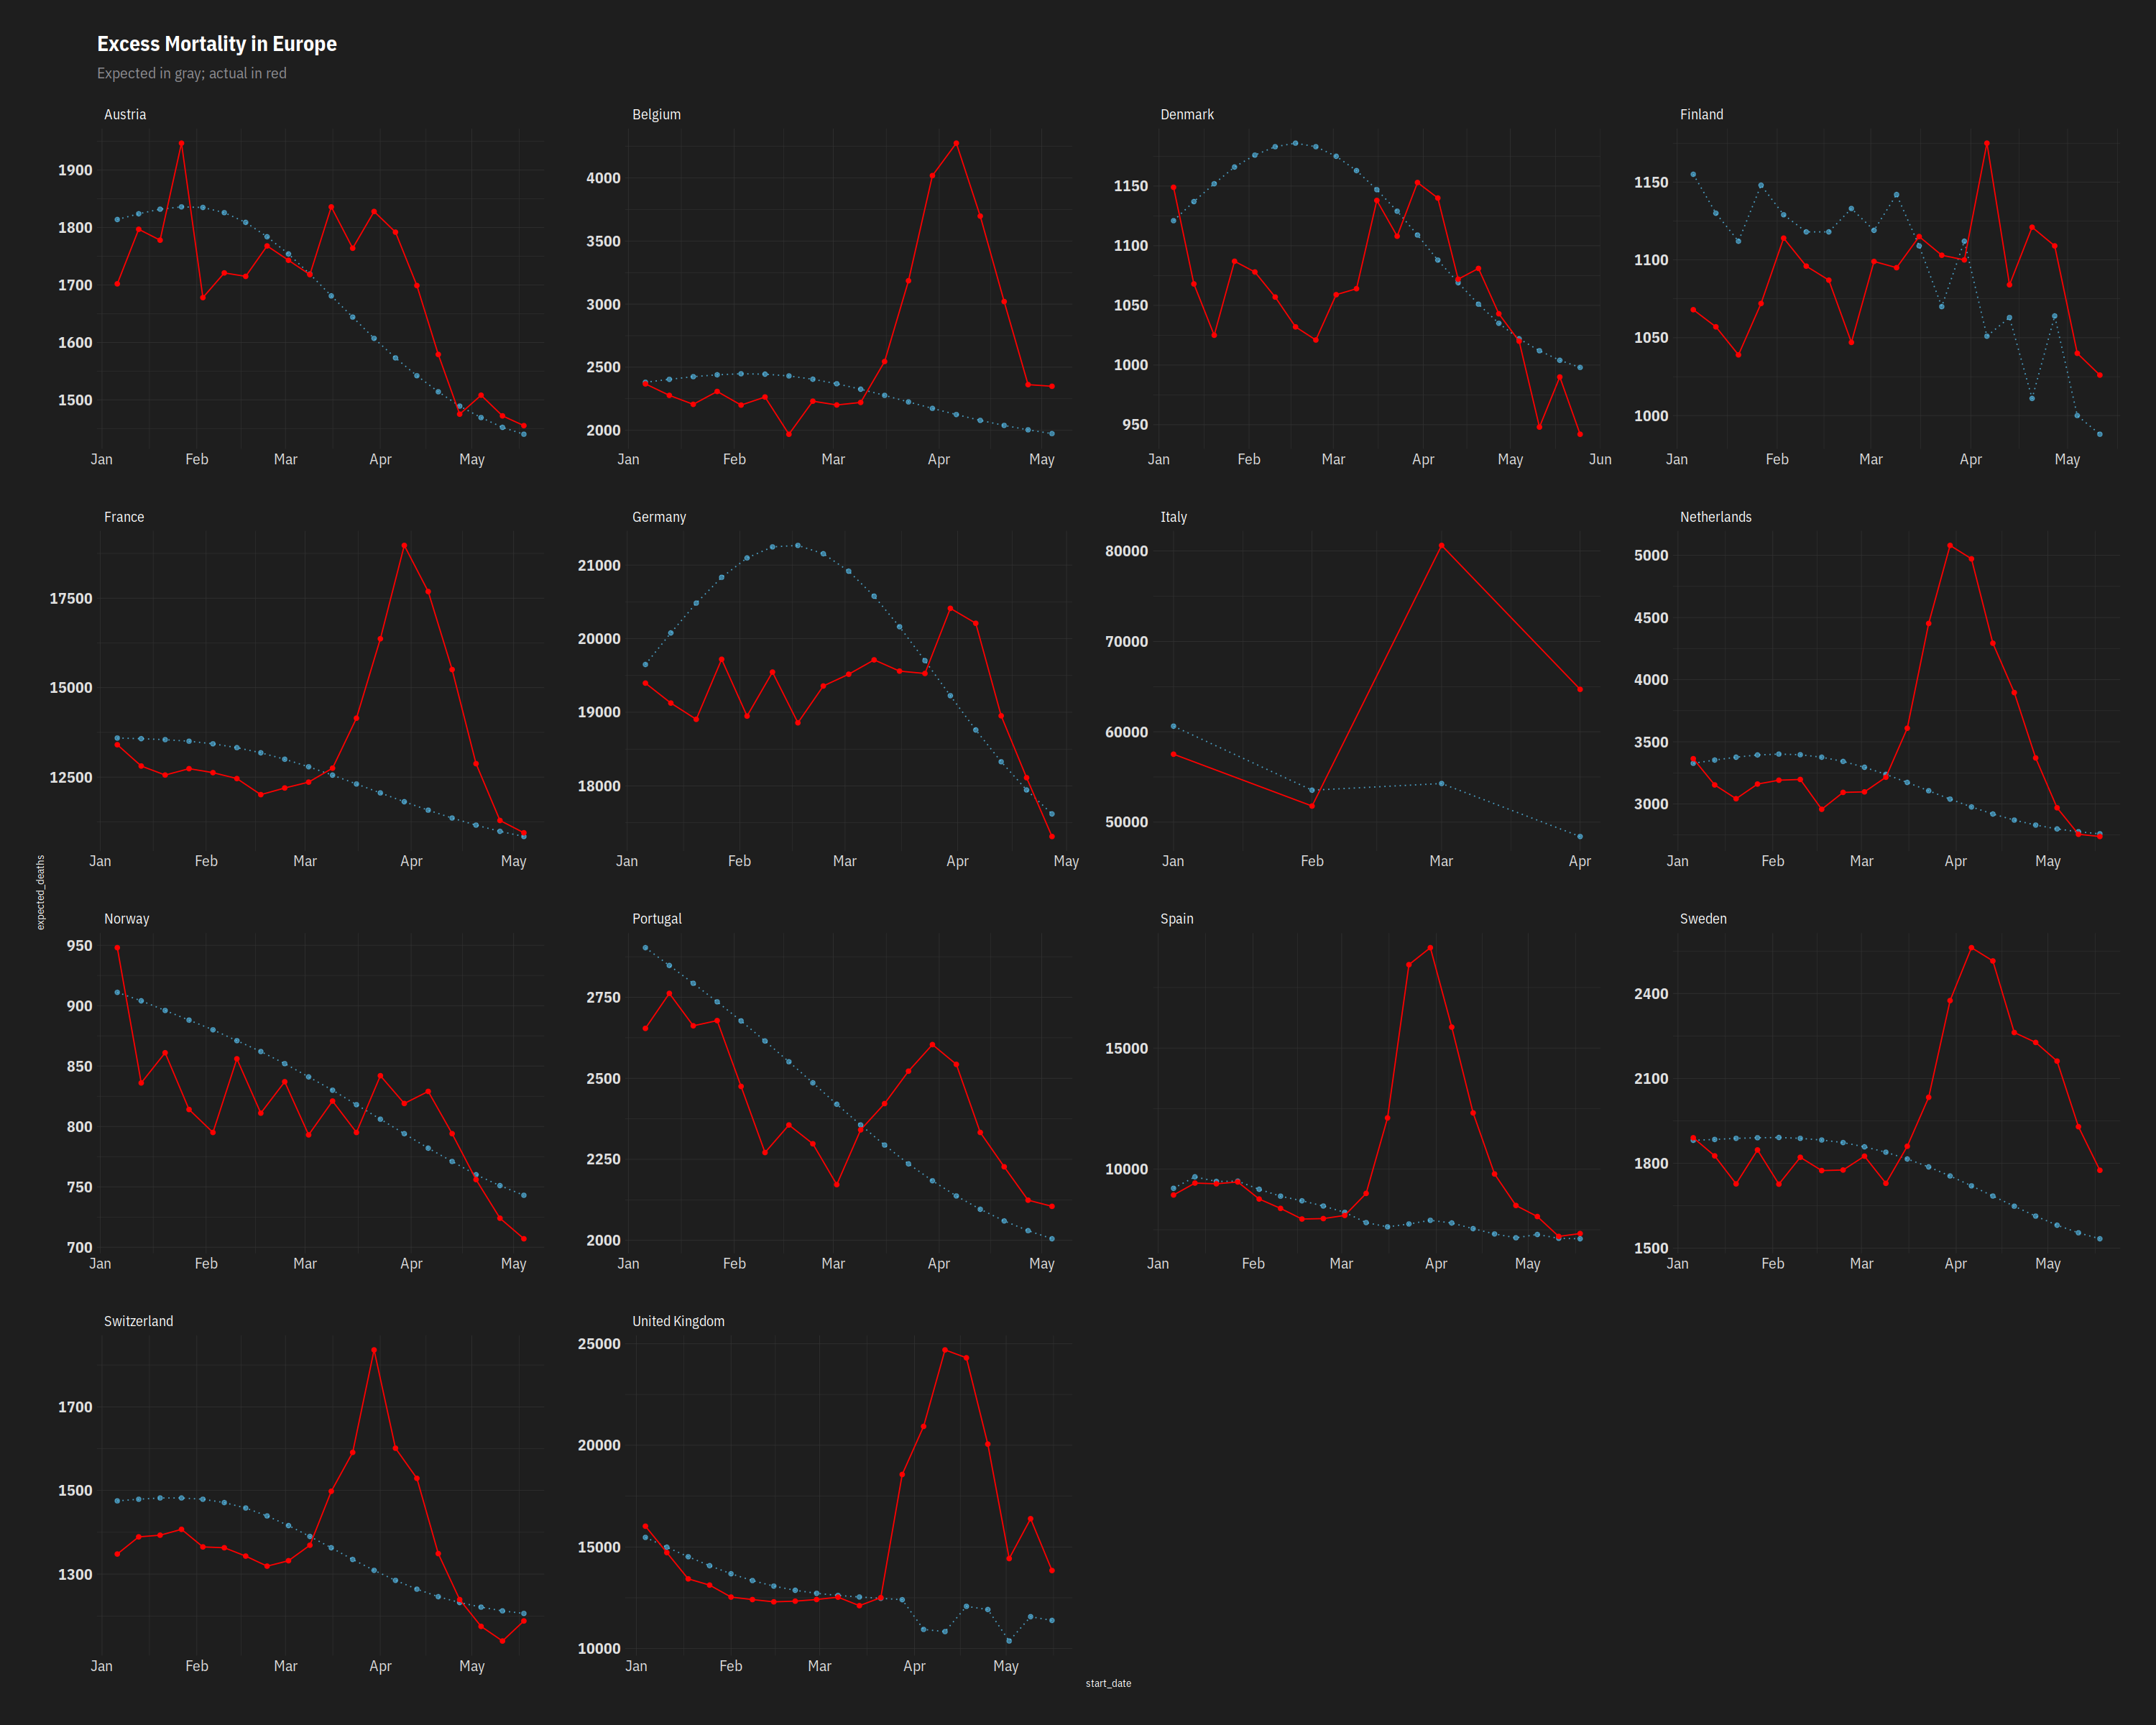

In [30]:
options(repr.plot.width = 25, repr.plot.height=20)
ggplot(eur, aes(x = start_date, y = expected_deaths)) +
    geom_point(alpha = 0.6) + geom_line(linetype = 'dotted', alpha = 0.8) +
    geom_point(aes(y = deaths), colour = 'red') + geom_line(aes(y = deaths), colour = 'red') +
    facet_wrap(~ country, scales = 'free') +
    labs(title = "Excess Mortality in Europe", subtitle = "Expected in gray; actual in red") 

In [31]:
us_samp = exmort_nyt[year == 2020 & country == "United States" & placename != ""]
us_samp[, dt := ifelse(is.na(start_date), year + month, year + month + week - 1)]
us_samp[, .SD[1:2], by = placename] 

placename     country       frequency start_date end_date   year month week
1  Boston        United States weekly    2020-01-05 2020-01-05 2020 1      2  
2  Boston        United States weekly    2020-01-12 2020-01-12 2020 1      3  
3  New York City United States weekly    2020-01-05 2020-01-05 2020 1      2  
4  New York City United States weekly    2020-01-12 2020-01-12 2020 1      3  
5  Miami         United States monthly   <NA>       <NA>       2020 1     NA  
6  Miami         United States monthly   <NA>       <NA>       2020 2     NA  
7  Chicago       United States weekly    2020-01-05 2020-01-05 2020 1      2  
8  Chicago       United States weekly    2020-01-12 2020-01-12 2020 1      3  
9  Denver        United States monthly   <NA>       <NA>       2020 1     NA  
10 Denver        United States monthly   <NA>       <NA>       2020 2     NA  
11 Detroit       United States weekly    2020-01-05 2020-01-05 2020 1      2  
12 Detroit       United States weekly    2020-01-12 2020-01-12 2020 1      3  
   deaths expected_deaths excess_deaths baseline                    dt  
1   373    395             -22          2015-2019 historical data   2022
2   389    392              -3          2015-2019 historical data   2023
3  1086   1194            -108          2015 - 2019 historical data 2022
4  1130   1145             -15          2015 - 2019 historical data 2023
5  1948   1941               7          2015 - 2019 historical data 2021
6  1813   1720              93          2015 - 2019 historical data 2022
7   894    906             -12          2017 - 2019 historical data 2022
8   857    899             -42          2017 - 2019 historical data 2023
9   415    417              -2          2017 - 2019 historical data 2021
10  385    381               4          2017 - 2019 historical data 2022
11  799    823             -24          2017 - 2019 historical data 2022
12  758    840             -82          2017 - 2019 historical data 2023

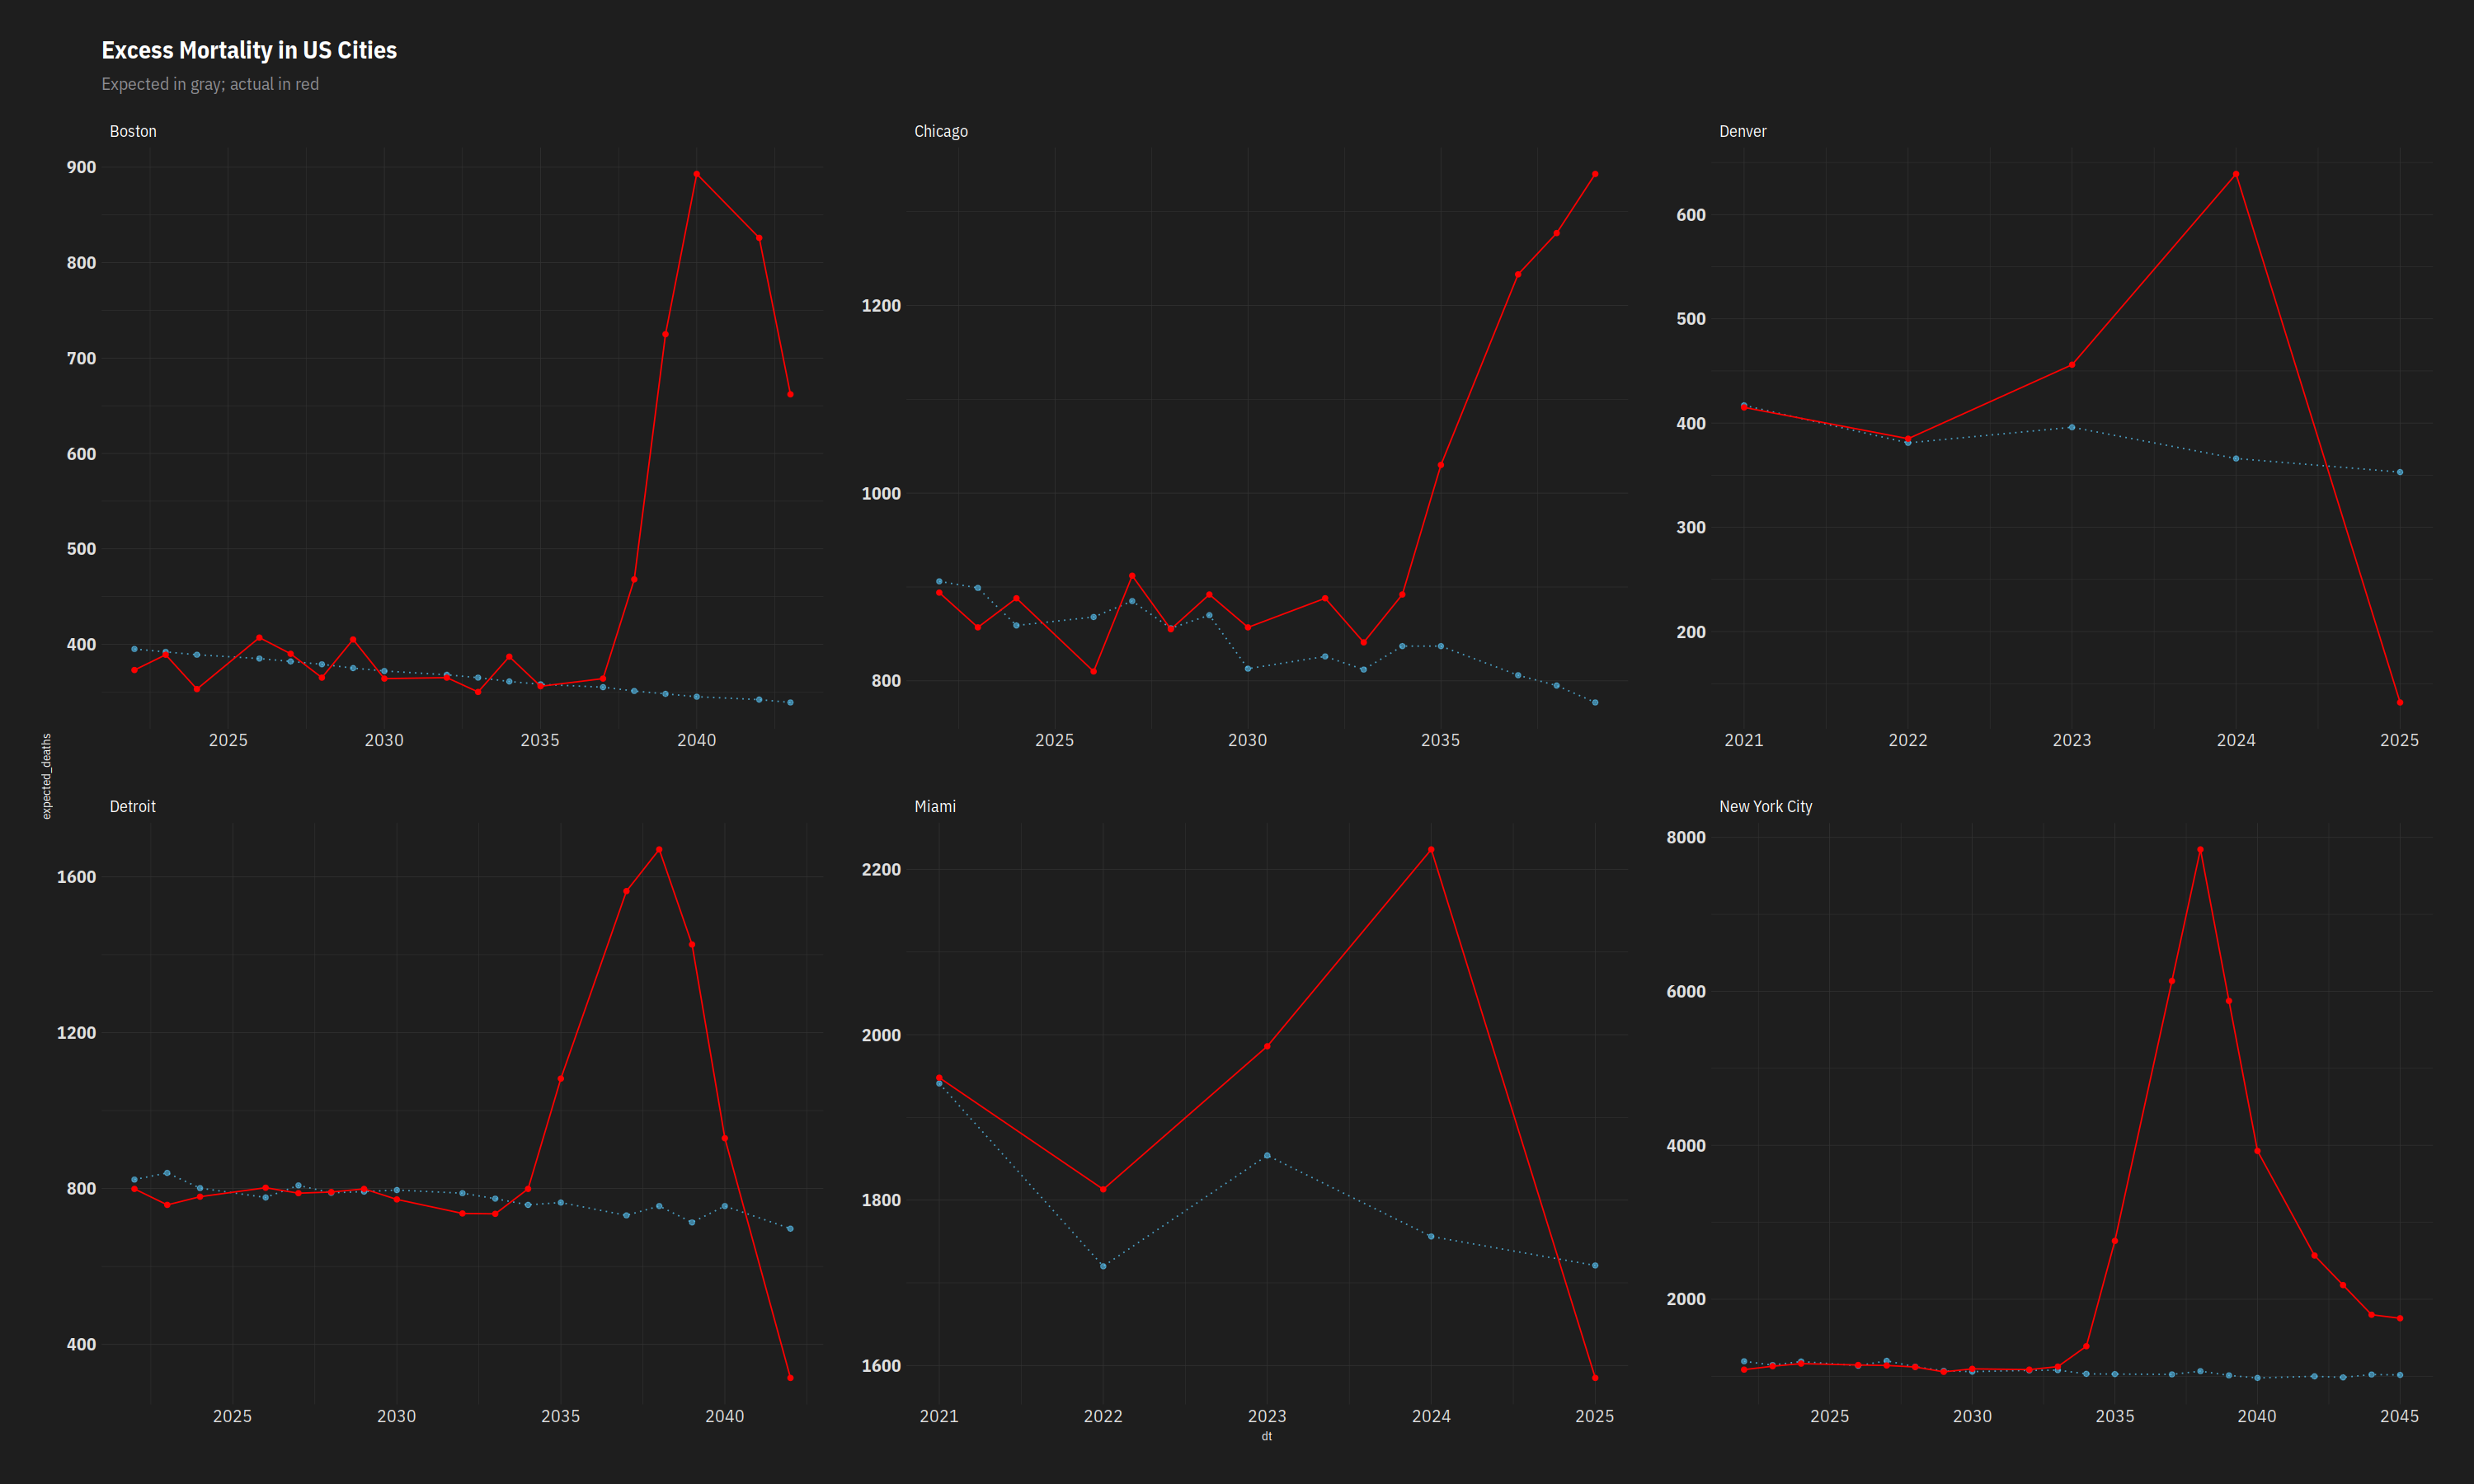

In [33]:
options(repr.plot.width = 25, repr.plot.height=15)
ggplot(us_samp, aes(x = dt, y = expected_deaths)) +
    geom_point(alpha = 0.6) + geom_line(linetype = 'dotted', alpha = 0.8) +
    geom_point(aes(y = deaths), colour = 'red') + geom_line(aes(y = deaths), colour = 'red') +
    facet_wrap(~ placename, scales = 'free') +
    labs(title = "Excess Mortality in US Cities", subtitle = "Expected in gray; actual in red") 